## QBUS6840 - Assignment

<a id='ToC'></a>
<u>**Table of Contents**</u>

1. [Load and Prepare Data](#1.0)
    - Load csv from `data` folder
    - Pre-process dataset to create Time Series
2. [Exploratory Analysis & Summary](#2.0)
    - Plots and Statistical Summary
    - Observing Trends and Averages
    - [Decomposition](#2.3)
    - Other Transformations
3. [Model Development](#3.0)
    - [Exponential Smoothing](#3.1)
    - [Seasonal ARIMA](#3.2)
    - [Neural Network (incl. Autoregression and Recurrent)](#3.3)
    - To discuss: Convolutional NN?
4. [Model Training & Scoring](#4.0)
5. [Evaluation Test Set](#5.0)
6. Evaluate on Test Data

<a id='1.0'></a>
## 1. Load and Prepare Data
- 1.1 Data Loading

[Return to top](#ToC)

### 1.1 Data Loading

In [1]:
# Standard Packages
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Time Series Analysis (incl. decomposition, exponential smoothing and ARIMA)
from sklearn.linear_model import LinearRegression
import statsmodels as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import pmdarima as pm # For Auto-ARIMA (grid search using AIC/BIC)

# For Deep Learning
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.layers import Dense, Flatten, TimeDistributed, SimpleRNN
from keras.models import Sequential
from keras.layers.convolutional import Conv1D, MaxPooling1D

In [2]:
# Load functions and classes from our utilities
from QBUS_utilities import ts_cross_val_split, SimpleModel, RMSE, MAPE
from sklearn.model_selection import TimeSeriesSplit

In [3]:
# Set random seed for project
tf.random.set_seed(51)
np.random.seed(51)

In [21]:
# load data - there are no missing values (475 out of 475 count)
df_raw = pd.read_csv('data/UnderemploymentRate_InSample.csv')

display(df_raw.info())
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  475 non-null    object 
 1   Underemployment Rate  475 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.5+ KB


None

,Date,Underemployment Rate
0,1/06/1978,4.270054
1,1/07/1978,3.933794
2,1/08/1978,4.045333
3,1/09/1978,3.999336
4,1/10/1978,3.722322


In [20]:
# Convert Date to datetime and set as index
df_ts = df_raw.copy()
df_ts['Date'] = pd.to_datetime(df_ts['Date'], format="%d/%m/%Y") # Fix format to day-month-year
df_ts = df_ts.set_index('Date')
df_ts.index.freq = 'MS'
df_ts.head()

,Underemployment Rate
Date,
1978-06-01,4.270054
1978-07-01,3.933794
1978-08-01,4.045333
1978-09-01,3.999336
1978-10-01,3.722322


<a id='2.0'></a>
## 2. Exploratory Data Analysis
- 2.1 Plot and Statistical Summary
- 2.2 Observing Trends and Averages
- 2.3 Decomposition
- 2.4 Transformations (EDA only)

[Return to top](#ToC)

### 2.1 Plot and Statistical Summary

Convert data to `datetime` and set is as the index. Then plot the time series.

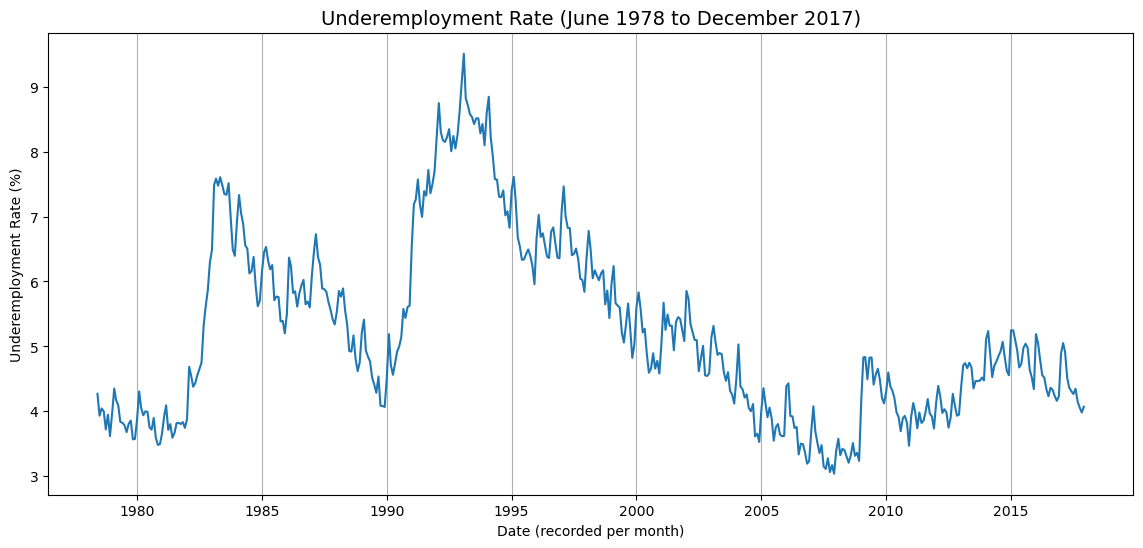

In [6]:
# Plot the training dataset
plt.figure(figsize=(14,6))
plt.title('Underemployment Rate (June 1978 to December 2017)', fontsize=14)
plt.xlabel('Date (recorded per month)', fontsize=10)
plt.ylabel('Underemployment Rate (%)', fontsize=10)

plt.gca().xaxis.grid(True)
plt.plot(df_ts.index, df_ts['Underemployment Rate'])

plt.show()

Plot the box and whisker plot and summarize the descriptive statistics about the series.

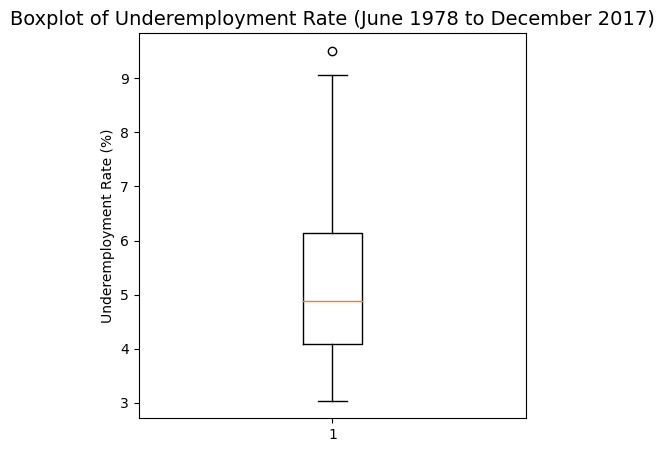

,Underemployment Rate
count,475.0000
mean,5.2175
std,1.3862
min,3.0395
25%,4.0932
50%,4.8875
75%,6.1373
max,9.5068


In [22]:
plt.figure(figsize=(5,5))
plt.title('Boxplot of Underemployment Rate (June 1978 to December 2017)', fontsize=14)
plt.boxplot(df_ts)
plt.ylabel('Underemployment Rate (%)', fontsize=10)
plt.show()

df_ts.describe().style.format(precision=4)

Identify where the maximum and minimum value occurs. Later, in EDA, we explore average rates over 5 and 10 year periods.

In [6]:
print('--------')
print(f"The maximum underemployment rate, {max(df_ts['Underemployment Rate']):.4f}%, \
is found on {df_ts.index[np.argmax(df_ts['Underemployment Rate'])]}")
print('--------')
print(f"The minimum underemployment rate, {min(df_ts['Underemployment Rate']):.4f}%, \
is found on {df_ts.index[np.argmin(df_ts['Underemployment Rate'])]}")
print('--------')

--------
The maximum underemployment rate, 9.5068%, is found on 1993-02-01 00:00:00
--------
The minimum underemployment rate, 3.0395%, is found on 2007-12-01 00:00:00
--------


### 2.2 Observing Trends and Averages

Plot the data with annual smoothing to see the trend.

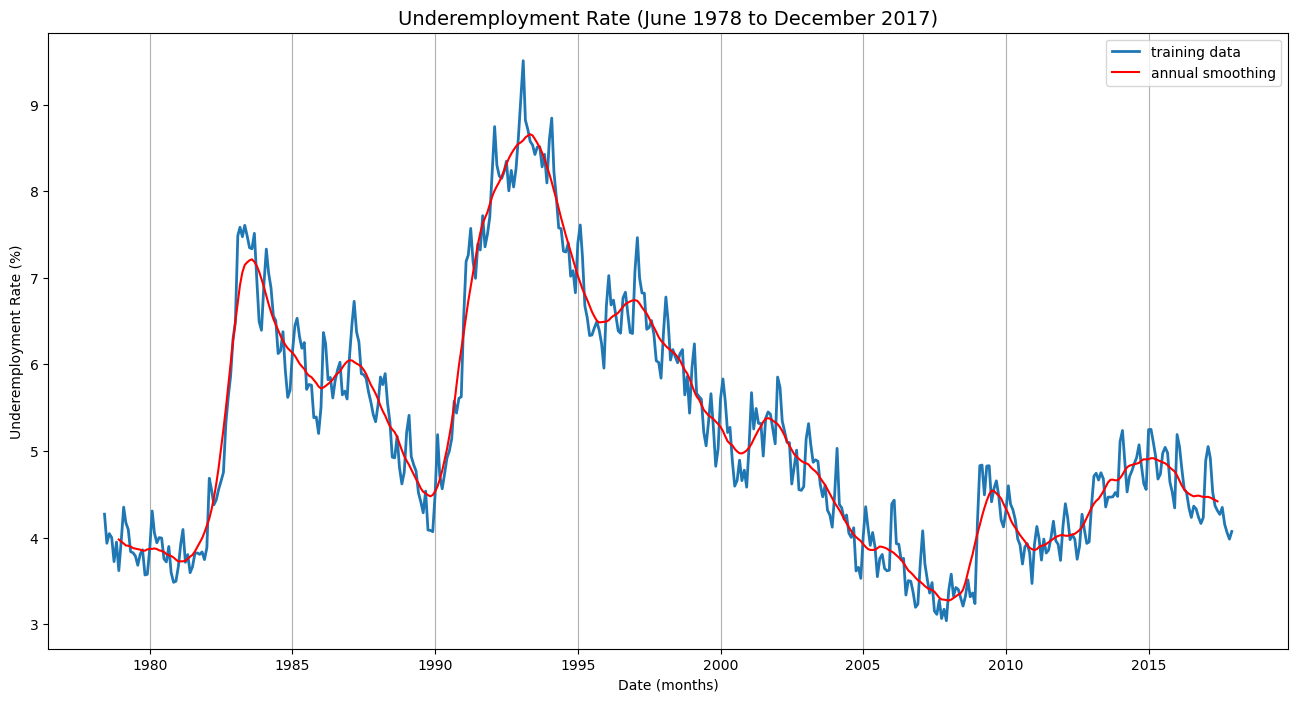

In [25]:
# Smooth the plot
df_annual_smoothing = df_ts.rolling(12, center=True).mean().rolling(2, center=True).mean().shift(-1)

# Plot the training dataset
plt.figure(figsize=(16,8))
plt.title('Underemployment Rate (June 1978 to December 2017)', fontsize=14)
plt.xlabel('Date (months)', fontsize=10)
plt.ylabel('Underemployment Rate (%)', fontsize=10)

plt.plot(df_ts.index, df_ts['Underemployment Rate'], label='training data', linewidth=2)
plt.plot(df_annual_smoothing.index, df_annual_smoothing['Underemployment Rate'], label='annual smoothing', color='red')

plt.gca().xaxis.grid(True)
plt.legend()
plt.show()

Observe the average over a 5 year and 10 year period.

In [26]:
# Average rate (%) per 5 years
print('-----------------')
print('Average rate (%) per 5 year interval:')
df_five = df_ts['Underemployment Rate'].groupby(lambda x: int(x.year/5)).mean().reset_index(drop=True)
for i, year in enumerate(['1975+', '1980+', '1985+', '1990+', '1995+', '2000+', '2005+', '2010+', '2015+']):
    print(f'{year}: {df_five[i]:.4f}%')

# Average per decade
print('-----------------')
print('Average rate (%) per decade:')
df_decade = df_ts['Underemployment Rate'].groupby(lambda x: int(x.year/10)).mean().reset_index(drop=True)
for i, year in enumerate(['1970s', '1980s', '1990s', '2000s', '2010s']):
    print(f'{year}: {df_decade[i]:.4f}%')

-----------------
Average rate (%) per 5 year interval:
1975+: 3.8975%
1980+: 5.2324%
1985+: 5.5175%
1990+: 7.3866%
1995+: 6.2747%
2000+: 4.8486%
2005+: 3.7684%
2010+: 4.2862%
2015+: 4.5944%
-----------------
Average rate (%) per decade:
1970s: 3.8975%
1980s: 5.3750%
1990s: 6.8306%
2000s: 4.3085%
2010s: 4.4017%


<u> **Trial**: Explore multi-year seasonality. </u>

Apply 5 year smoothing to observe the pattern over time, as well as identify if there is a fixed period.

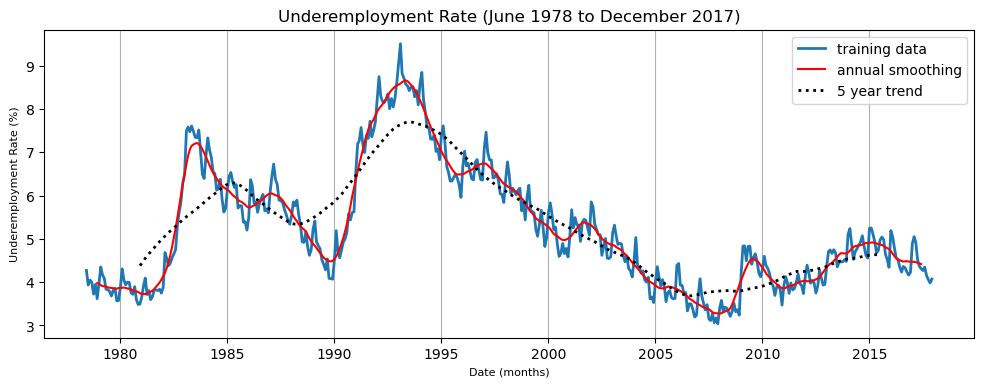

In [27]:
# The trend over time is still quite volatile, we explore multi-year seasonality
## Based on the average rate over 5 year intervals, this might show the general trend

# Let's smooth the plot
df_annual_smoothing = df_ts.rolling(12, center=True).mean().rolling(2, center=True).mean().shift(-1)
df_5year_smoothing = df_ts.rolling(60, center=True).mean().rolling(2, center=True).mean().shift(-1)

# Plot the training dataset
plt.figure(figsize=(12, 4))
plt.title('Underemployment Rate (June 1978 to December 2017)', fontsize=12)
plt.xlabel('Date (months)', fontsize=8)
plt.ylabel('Underemployment Rate (%)', fontsize=8)

plt.plot(df_ts.index, df_ts['Underemployment Rate'], label='training data', linewidth=2)
plt.plot(df_annual_smoothing.index, df_annual_smoothing['Underemployment Rate'], label='annual smoothing', color='red')
plt.plot(df_5year_smoothing.index, df_5year_smoothing['Underemployment Rate'],
         label='5 year trend', color='black', linestyle='dotted', linewidth=2)

plt.gca().xaxis.grid(True)
plt.legend()
plt.show()

While this does show smoothing and general direction, this is insufficient to conclude a seasonal pattern. We can observe the peaks/troughs of the plot don't occur in consistent intervals. Rather, this suggests possible cyclical patterns over time.

<a id='2.3'></a>
### 2.3 Decomposition for EDA

We can apply decomposition to further interpret the plot over time.

For **Additive Decomposition**, we can calculate the Trend, $Y_{T}$ and Seasonal $Y_{S}$:

$$y_{t} = T_{t} + S_{t} + C_{t} + \epsilon_{t}$$

1. Estimate the Trend using an $k=M$ Moving Average:
$$\hat{T_{t}} = MA(k) \text{ for } y_{1:T}$$

2. Remove $T_{t}$ from $Y_{t}$ for the de-trended series. Use this to estimate the average season for each period $M=12$:
$$Detrended = Y_{t} - T_{t}$$
$$\bar{s_{m}} = \frac{1}{n}\sum_{i=1}^{n}{Y_{t\%M = m}} \quad \text{for each } m \text{ in } M$$

3. Calculate the Normalising Constant, $c$:
$$c = \frac{1}{M} \sum_{m=1}^{M}{s_{m}}$$

4. Calculate the Normalised Seasonal Component:
$$S_{m} = {s_{m} - c} \quad \text{for each } m \text{ in } M$$

5. Remove $S_{t}$ from ${y_{t}}$ and re-estimate the Trend:
$$\hat{\hat{T_{t}}} = y_{t} - S_{t}$$

6. Calculate the Trend using OLS and observe the Residuals to determine if the trend/seasonal is sufficient
$$\hat{\hat{T_{t}}} = T_{t} + C_{t}$$

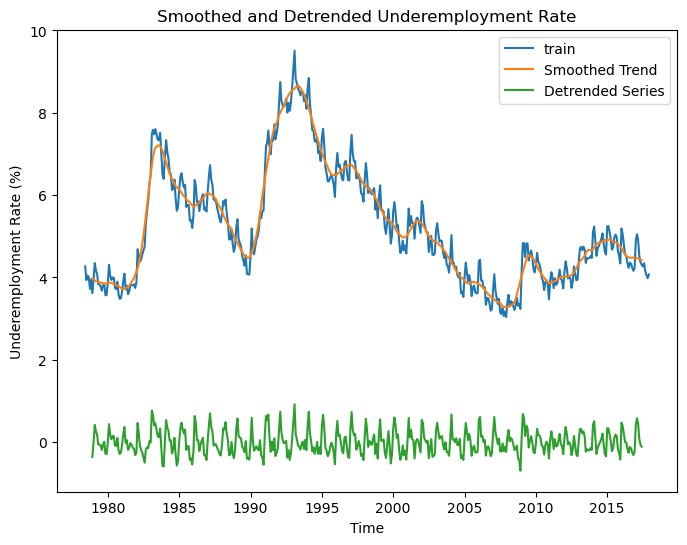

In [29]:
# 1. Estimate trend
df_trend_hat = df_annual_smoothing

# 2a. Calculate de-trended series
df_detrend = df_ts - df_trend_hat

plt.figure(figsize=(8,6))
plt.title('Smoothed and Detrended Underemployment Rate')
plt.ylabel('Underemployment Rate (%)')
plt.xlabel('Time')
plt.plot(df_ts, label='train')
plt.plot(df_trend_hat, label='Smoothed Trend')
plt.plot(df_detrend, label='Detrended Series')

plt.legend()
plt.show()

In [30]:
# 2b.
monthly_avg = df_detrend.groupby(lambda x: x.month).mean()

# 3.
normalising_constant = monthly_avg.mean()
print(f'The Normalising Constant, c = {normalising_constant.item():.4f}')

# 4.
monthly_norm = monthly_avg - normalising_constant
df_seasonal = df_ts.apply(lambda x: monthly_norm.loc[x.name.month].item(), axis=1)
df_seasonal = pd.DataFrame(df_seasonal, columns=['Underemployment Rate'])

print('The monthly seasonal component for additive seasonality:')
display(df_seasonal.head(12))

The Normalising Constant, c = -0.0004
The monthly seasonal component for additive seasonality:


,Underemployment Rate
Date,
1978-06-01,-0.042142
1978-07-01,-0.176330
1978-08-01,-0.112986
1978-09-01,0.023593
1978-10-01,-0.210674
1978-11-01,-0.270116
1978-12-01,-0.330840
1979-01-01,0.167793
1979-02-01,0.522157


In [31]:
# 5. 
df_deseasonalised = df_ts - df_seasonal

# 6.
X = np.arange(len(df_deseasonalised)).reshape(-1,1)

y_trend = df_deseasonalised.values.reshape(-1,1)
model_trend_linear = LinearRegression().fit(X, y_trend)

df_trend_fit = model_trend_linear.predict(X)

# And calculate the residuals
df_residual_smooth = df_annual_smoothing - df_deseasonalised
df_residual_linear = y_trend - df_trend_fit

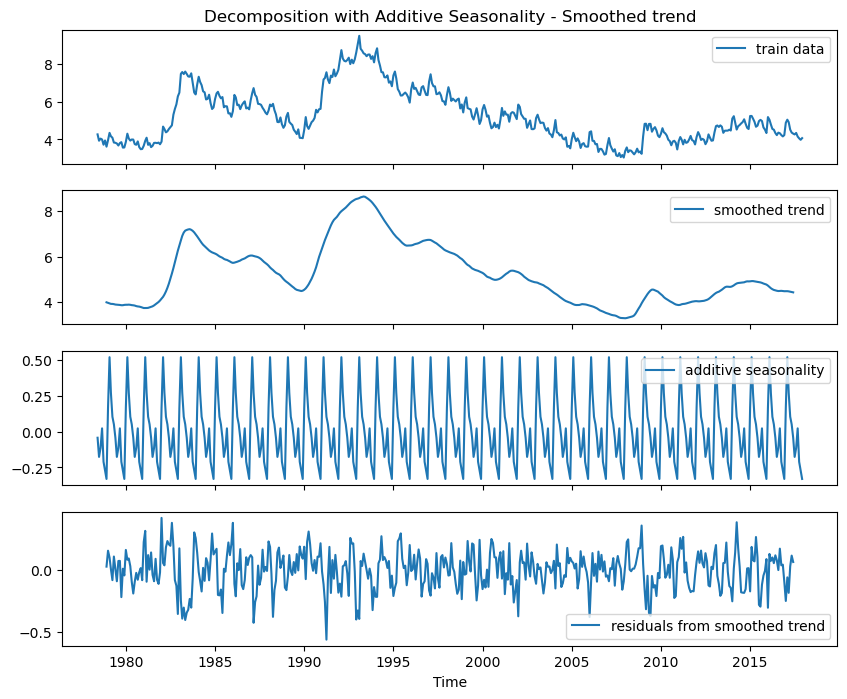

In [37]:
# Plot the decomposition
fig, ax = plt.subplots(4, 1,figsize=(10,8), sharex=True)
ax[0].set_title('Decomposition with Additive Seasonality - Smoothed trend')
ax[0].plot(df_ts, label='train data')
ax[0].legend()
ax[1].plot(df_annual_smoothing, label='smoothed trend')
ax[1].legend()
ax[2].plot(df_seasonal, label='additive seasonality')
ax[2].legend()
ax[3].plot(df_residual_smooth, label='residuals from smoothed trend')
ax[3].legend()
ax[3].set_xlabel('Time')

plt.legend()

plt.show()

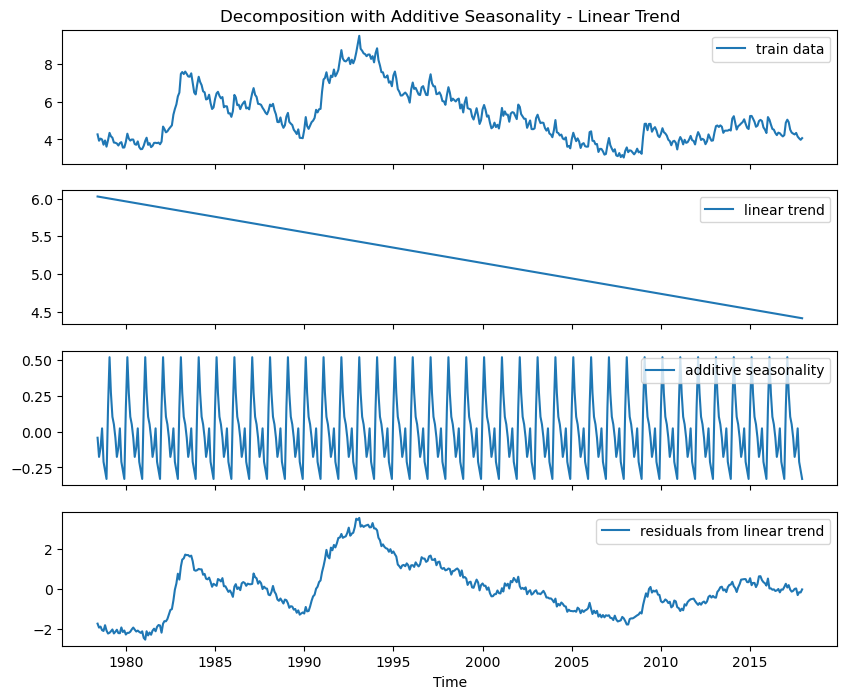

In [38]:
# Plot the decomposition
fig, ax = plt.subplots(4, 1,figsize=(10,8), sharex=True)
ax[0].set_title('Decomposition with Additive Seasonality - Linear Trend')
ax[0].plot(df_ts, label='train data')
ax[0].legend()
ax[1].plot(df_ts.index, df_trend_fit, label='linear trend')
ax[1].legend()
ax[2].plot(df_seasonal, label='additive seasonality')
ax[2].legend()
ax[3].plot(df_ts.index, df_residual_linear, label='residuals from linear trend')
ax[3].legend()
ax[3].set_xlabel('Time')

plt.legend()

plt.show()

**CAN CHECK OUR RESULTS:** Similarly, by utilising the statsmodels package, we can quickly find the trend and seasonality and review the residuals to determine if the trend is captured effectively.


####---- Decomposition Plot: additive model ----####
Seasonality, m = 12


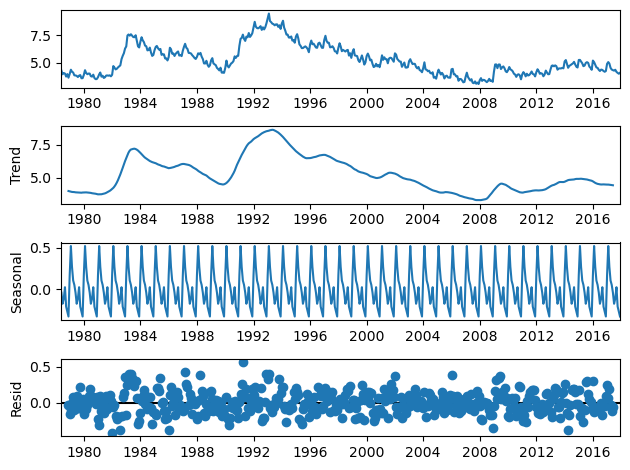


####---- Decomposition Plot: multiplicative model ----####
Seasonality, m = 12


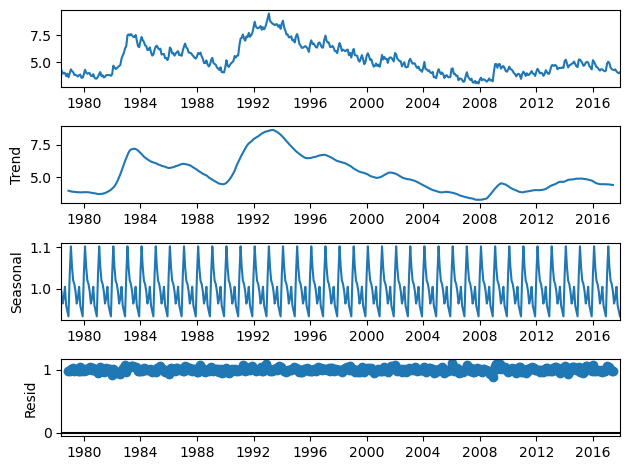

In [39]:
for model_type in ['additive', 'multiplicative']:
    decomposition = sm.tsa.seasonal.seasonal_decompose(df_ts,
                                                       model = model_type,
                                                       period = None,
                                                      )
    print(f'\n####---- Decomposition Plot: {model_type} model ----####')
    print(f'Seasonality, m = {decomposition.seasonal.nunique()}')
    decomposition.plot()

    plt.show()

We see the through decomposition there is seasonal period m = 12. Further, forcing other seasonal periods worsens the residual plot.


####---- Decomposition Plot: additive model ----####
Seasonality, m = 30


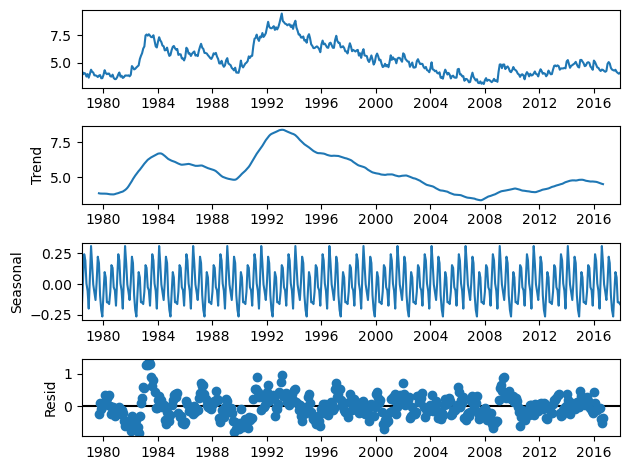


####---- Decomposition Plot: multiplicative model ----####
Seasonality, m = 60


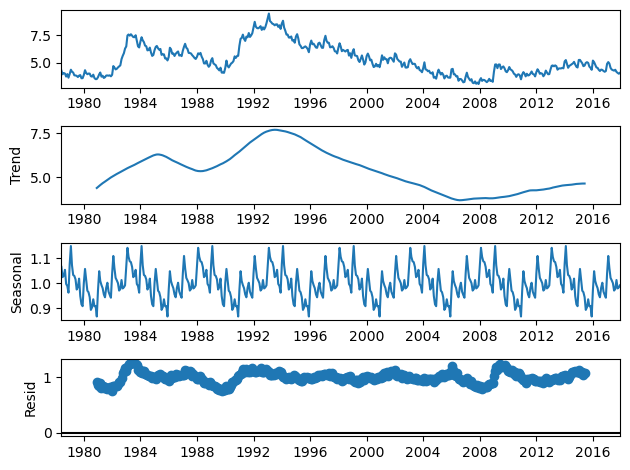

In [40]:
for model_type, model_seasons in zip(['additive', 'multiplicative'], [30, 60]):
    decomposition = sm.tsa.seasonal.seasonal_decompose(df_ts,
                                                       model = model_type,
                                                       period = model_seasons,
                                                      )
    print(f'\n####---- Decomposition Plot: {model_type} model ----####')
    print(f'Seasonality, m = {decomposition.seasonal.nunique()}')
    decomposition.plot()

    plt.show()

### 2.4 Transformations

***Note:** These transformations are exploratory only. After earlier trials, these are not used further in this notebook. Differencing is applied more purposefully after evaluating ACF/PACF in [Section 3.2](#3.2).*

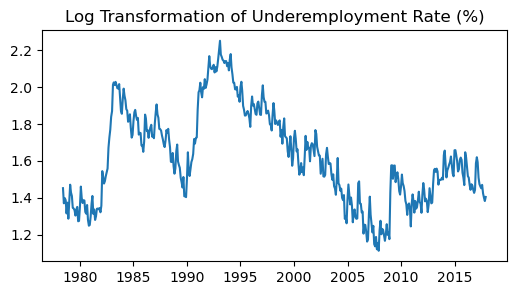

In [44]:
# Transformation:
## (a) log scale
plt.figure(figsize=(6,3))
plt.title('Log Transformation of Underemployment Rate (%)')
df_log = np.log(df_ts)
plt.plot(df_log)
plt.show()

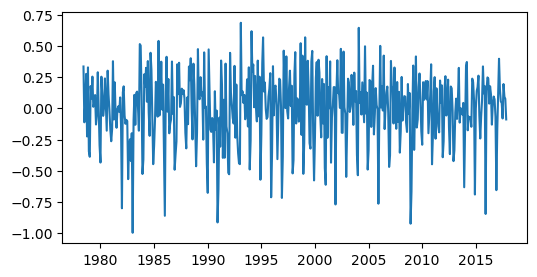

In [42]:
# Transformation:
## (b) Differencing
plt.figure(figsize=(6,3))
plt.title('Differencing of Undermployment Rate (%)')
df_diff = df_ts - df_ts.shift(-1)
plt.plot(df_diff)
plt.show()

In [ ]:
# EXTRA

<a id='3.0'></a>
## 3. Model Development
- 3.1 Exponential Smoothing
- 3.2 ARIMA
- 3.2 Neural Networks

[Return to top](#ToC)

For modelling, we need to quickly identify candidate models to evaluate using an expanding window cross-validation set. Typically, hyper-parameters are tuned using this cross-validation and then trained on the whole dataset before evaluating on the test data.

However, given the scope of models explored and number of hyper-parameters, we are only using one training/validation split to optimize and fit each type of model. Cross-Validation for high-performing models and hyper-parameter settings are then all evaluated in **[Section 4](#4.0)** to select the best model to use with the test set

In [45]:
forecast_window = 24
ts_train = df_ts[:-forecast_window]
ts_val = df_ts[-forecast_window:]
print(f'Training data is split into Train - {ts_train.shape} and Validation - {ts_val.shape}')

Training data is split into Train - (451, 1) and Validation - (24, 1)


<a id="3.1"></a>
### 3.1 Exponential Smoothing
- Simple Exponential Smoothing
- Holt Smoothing
- Holt-Winters Smoothing

[Return to top](#ToC)

#### 3.1.1 Simple Exponential Smoothing

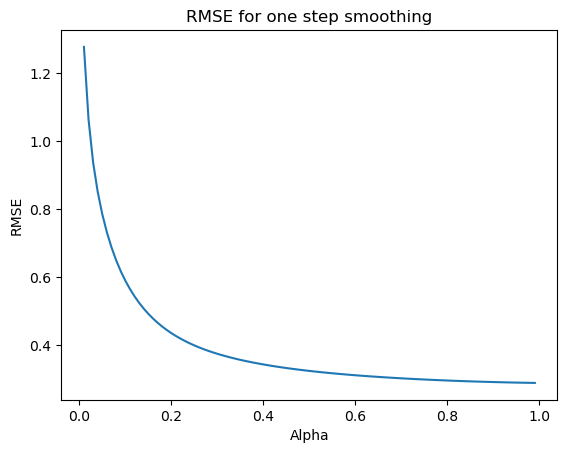

Optimal Alpha for 1-step forecast = 0.9900


In [46]:
# Create values for alpha
alphas = np.arange(0.01,1,0.01)

# Initialize an empty list to store RMSE for each value of alpha
rmse_alphas = []

# Loop through alphas
for a in alphas:
    smoothed = ts_train.ewm(alpha = a, adjust=False).mean()
    rmse_alphas.append(RMSE(ts_train[1:], smoothed[:-1]))
    
# Plot the error for each alpha
plt.figure()
plt.plot(alphas, rmse_alphas)
plt.title("RMSE for one step smoothing")
plt.ylabel("RMSE")
plt.xlabel("Alpha")

plt.show()

# Find the best alpha
optimal_alpha = alphas[np.argmin(rmse_alphas)]
print(f'Optimal Alpha for 1-step forecast = {optimal_alpha:.4f}')

In [47]:
SES = SimpleExpSmoothing(ts_train).fit()
print('Simple Exponential Smoothing model fit...')

y_fitted = SES.predict(start=ts_train.index[0], end=ts_train.index[-1])
y_preds = SES.forecast(len(ts_val))
print('-----------------------')
print('      Scoring SES      ')
print('-----------------------')
print(f'RMSE on training set  : {RMSE(ts_train, y_fitted):.4f}')
print(f'RMSE on validation set: {RMSE(ts_val, y_preds):.4f}')
print('-----------------------')

Simple Exponential Smoothing model fit...
-----------------------
      Scoring SES      
-----------------------
RMSE on training set  : 0.2872
RMSE on validation set: 0.3572
-----------------------


#### 3.1.2 Trend Corrected Exponential Smoothing

$$ Y_{t+1} = l_{t} + b_{t} + \epsilon_{t+1} $$
$$ l_{t} = \alpha Y_{t} + (1 - \alpha)(l_{t-1} + b_{t-1}) $$
$$ b_{t} = \beta(l_{t} - l_{t-1}) + (1 - \beta)b_{t-1} $$
$$ \epsilon_{t+1} \sim \mathcal{N}(\mu,\,\sigma^{2}) $$

In [53]:
np.arange(0.01,1,0.05)

array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96])

In [54]:
# Create values for alpha and beta
alphas = np.arange(0.01,1,0.05) # Note: Takes a while - either improve or run at end full (not used later anyway)
betas = np.arange(0.01,1,0.05)
# Initialize l0 and b0
l_0 = df_ts.iloc[0]
b_0 = df_ts.iloc[1] - l_0

# Initialize an empty list to store RMSE for each value of alpha and betas
rmse_alphas_betas = np.zeros((len(alphas),len(betas)))

# Evaluate combinations of alpha and beta
for k, alpha in enumerate(alphas):
    if alpha*100%10==1: print(f'{alpha*100}% complete')
    for j, beta in enumerate(betas):
        # Initialize values
        holts_linear = []
        l = [l_0]
        b = [b_0]
        
        for i in range(len(ts_train)):
            l.append(alpha * ts_train.iloc[i] + (1 - alpha)*(l[i] + b[i])) # Calculate level l_t
            b.append(beta*(l[i+1] - l[i]) + (1 - beta)*b[i])               # Calcualate trend b_t
            holts_linear.append(l[i+1] + b[i+1])                           # Y_t = l_t + b_t
        
        rmse_alphas_betas[k, j] = RMSE(holts_linear[:-1], ts_train.iloc[1:])

rmse_alphas_betas

0.060000000000000005% complete
0.56% complete


array([[11.42578638,  5.05286948,  3.78279901,  3.72768706,  3.86657651,
         3.90939102,  3.7395862 ,  3.30957915,  2.78029651,  2.25209768,
         1.84852654,  1.61194827,  1.52852114,  1.57017009,  1.69822699,
         1.85519526,  1.98389273,  2.05914123,  2.0817066 ,  2.0603617 ],
       [ 2.10020214,  1.1673406 ,  0.95381614,  0.89536282,  0.88390365,
         0.87049165,  0.84276884,  0.8053433 ,  0.76458335,  0.72776832,
         0.69859985,  0.67597959,  0.65646867,  0.63734896,  0.61862004,
         0.60308085,  0.59392238,  0.59259631,  0.59839955,  0.60893253],
       [ 1.21058336,  0.72442732,  0.646326  ,  0.61226455,  0.58145801,
         0.55309386,  0.53022012,  0.51307648,  0.50120439,  0.49440464,
         0.49161893,  0.49065161,  0.48930317,  0.48653355,  0.48264937,
         0.47868857,  0.47569027,  0.47427726,  0.47460873,  0.47653904],
       [ 0.87538165,  0.56326681,  0.51291526,  0.48557439,  0.46550917,
         0.45177597,  0.44346102,  0.4390798 ,  

In [61]:
x, y = np.unravel_index(np.argmin(rmse_alphas_betas), rmse_alphas_betas.shape)

optimal_alpha = alphas[x]
optimal_beta = betas[y]

print(f'Optimal alpha: {optimal_alpha:.4f}')
print(f'Optimal beta: {optimal_beta:.4f}')

## TODO: CHECK VALUES

Optimal alpha: 0.9600
Optimal beta: 0.0600


In [62]:
Holt_ES = Holt(ts_train).fit(smoothing_level=optimal_alpha,
                             smoothing_trend=optimal_beta
                            )

y_fitted = Holt_ES.predict(start=ts_train.index[0], end=ts_train.index[-1])
y_preds = Holt_ES.forecast(len(ts_val))

print('-----------------------')
print('     Scoring TCES      ')
print('-----------------------')
print(f'RMSE on training set  : {RMSE(ts_train, y_fitted):.4f}')
print(f'RMSE on validation set: {RMSE(ts_val, y_preds):.4f}')
print('-----------------------')

-----------------------
     Scoring TCES      
-----------------------
RMSE on training set  : 0.2935
RMSE on validation set: 0.4799
-----------------------


#### 3.1.3 Holt-Winters Exponential Smoothing

In [57]:
HoltWinters_add_ES = ExponentialSmoothing(ts_train, seasonal_periods=12, trend='add', seasonal='add').fit()
HoltWinters_mul_ES = ExponentialSmoothing(ts_train, seasonal_periods=12, trend='add', seasonal='mul').fit()

y_fitted = HoltWinters_add_ES.predict(start=ts_train.index[0], end=ts_train.index[-1])
y_preds = HoltWinters_add_ES.forecast(len(ts_val))

print('-----------------------')
print(' Scoring Additive HWES ')
print('-----------------------')
print(f'RMSE on training set  : {RMSE(ts_train, y_fitted):.4f}')
print(f'RMSE on validation set: {RMSE(ts_val, y_preds):.4f}')
print('-----------------------')

y_fitted = HoltWinters_mul_ES.predict(start=ts_train.index[0], end=ts_train.index[-1])
y_preds = HoltWinters_mul_ES.forecast(len(ts_val))

print('-----------------------')
print('Scoring Multiplicative HWES')
print('-----------------------')
print(f'RMSE on training set  : {RMSE(ts_train, y_fitted):.4f}')
print(f'RMSE on validation set: {RMSE(ts_val, y_preds):.4f}')
print('-----------------------')

-----------------------
 Scoring Additive HWES 
-----------------------
RMSE on training set  : 0.1843
RMSE on validation set: 0.1843
-----------------------
-----------------------
Scoring Multiplicative HWES
-----------------------
RMSE on training set  : 0.1883
RMSE on validation set: 0.2845
-----------------------


In [58]:
params = ['smoothing_level',
          'smoothing_trend',
          'smoothing_seasonal',
          'initial_level',
          'initial_trend',
         ]

print('Holt-Winters hyper-parameters:')

hw_params = pd.DataFrame(index=[r"$\alpha$", r"$\beta$", r"$\gamma$", r"$l_0$", "$b_0$",
                                r"$S_{0}$", r"$S_{1}$", r"$S_{2}$", r"$S_{3}$", r"$S_{4}$", r"$S_{5}$", r"$S_{6}$",
                                r"$S_{7}$", r"$S_{8}$", r"$S_{9}$", r"$S_{10}$", r"$S_{11}$", "SSE"],
                         columns=['Additive', 'Multiplicative']
                        )
hw_params['Additive'] = [HoltWinters_add_ES.params[p] for p in params] \
                    + [HoltWinters_add_ES.params['initial_seasons'][i] for i in range(12)] \
                    + [HoltWinters_add_ES.sse]

hw_params['Multiplicative'] = [HoltWinters_mul_ES.params[p] for p in params] \
                            + [HoltWinters_mul_ES.params['initial_seasons'][i] for i in range(12)] \
                            + [HoltWinters_mul_ES.sse]


hw_params.drop(index=[r"$S_{10}$", r"$S_{11}$"]).style.format(precision=4) #For some reason 10 and 11 display funny - can remove drop to view columns

Holt-Winters hyper-parameters:


,Additive,Multiplicative
$\alpha$,0.8064,0.7997
$\beta$,0.1331,0.1323
$\gamma$,0.0000,0.0000
$l_0$,4.2867,3.7700
$b_0$,-0.0395,-0.0307
$S_{0}$,-0.0095,1.1305
$S_{1}$,-0.1500,1.1047
$S_{2}$,-0.0858,1.1170
$S_{3}$,0.0515,1.1450
$S_{4}$,-0.1868,1.0947


**Holt-Winters Exponential Smoothing** outperforms other Exponential Smoothing models in both the training and validation set. This makes sense as we have determined there is annual seasonality in the data.

We will evaluate the performance difference between Additive and Multiplicative seasonality in the Model Evaluation section.

<a id="3.2"></a>
### 3.2 Seasonal ARIMA
- Stationarity
- Auto-Correlation and Partial Auto-Correlation Plots
- Seasonal ARIMA

[Return to top](#ToC)

#### 3.2.1 Stationarity

The time series is not stationary (i.e. the mean, variance and co-variance are a function of time).

To explore what differencing may be appropriate (incl. seasonal differencing), we apply the Augmented Dickey-Fuller test.

The Augmented Dickey-Fuller test for the original time series is:
	ADF = -2.0209
	P-Value = 0.2775

Plotting the ADF results for differencing, increased order by row and increased seasonal order by column



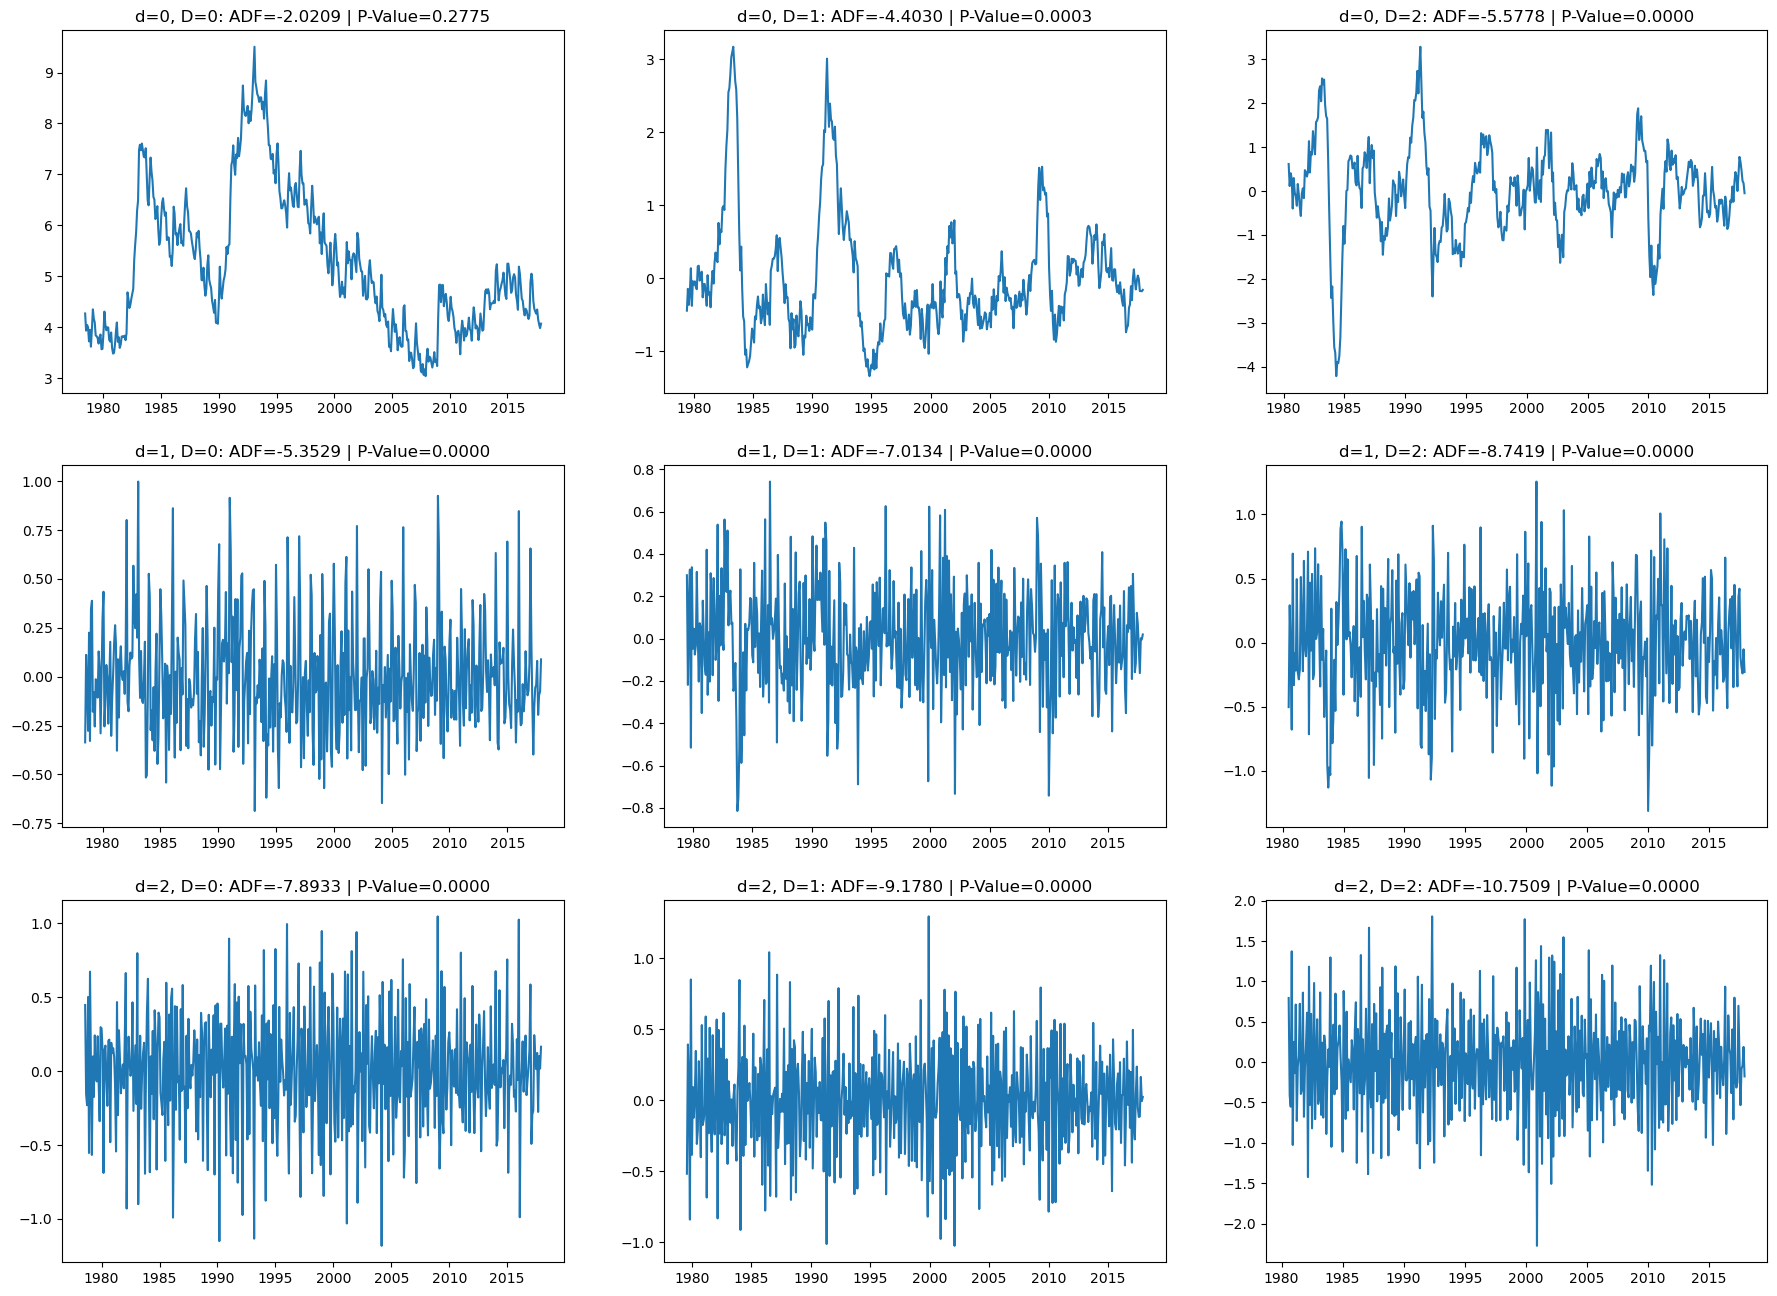

In [59]:
# We can apply the Augmented Dickey-Fuller test to evaluate stationarity, and then compare these to ACF/PACF plots below
adf_test = sm.tsa.stattools.adfuller(df_ts)
print(f'The Augmented Dickey-Fuller test for the original time series is:\n\tADF = {adf_test[0]:.4f}\n\tP-Value = {adf_test[1]:.4f}')
print()
print('Plotting the ADF results for differencing, increased order by row and increased seasonal order by column')
print()

# Plot the differencing
plt.figure(figsize=(22,16))
nrows, ncols = 3, 3

# Create a loop for differencing order [d, D]
for i, diff_plot in enumerate([[0, 0],
                               [0, 1],
                               [0, 2],
                               [1, 0],
                               [1, 1],
                               [1, 2],
                               [2, 0],
                               [2, 1],
                               [2, 2]
                              ]):
    plt.subplot(nrows, ncols, i+1)
    df_diff = df_ts.copy()
    
    for base_diff in range(diff_plot[0]):
        df_diff -= df_diff.shift(1)
        
    for seas_diff in range(diff_plot[1]):
        df_diff -= df_diff.shift(12)
        
    adf_test = sm.tsa.stattools.adfuller(df_diff.dropna())
    plt.title(f'd={diff_plot[0]}, D={diff_plot[1]}: ADF={adf_test[0]:.4f} | P-Value={adf_test[1]:.4f}')
    plt.plot(df_diff)
    
plt.show()

It looks like even first order differencing provides a suitable level of stationarity. While d=2, D=2 has the best score, any seasonal differencing or second order differencing has similar scores.

#### 3.2.2 Auto-Correlation and Partial Auto-Correlation Plots

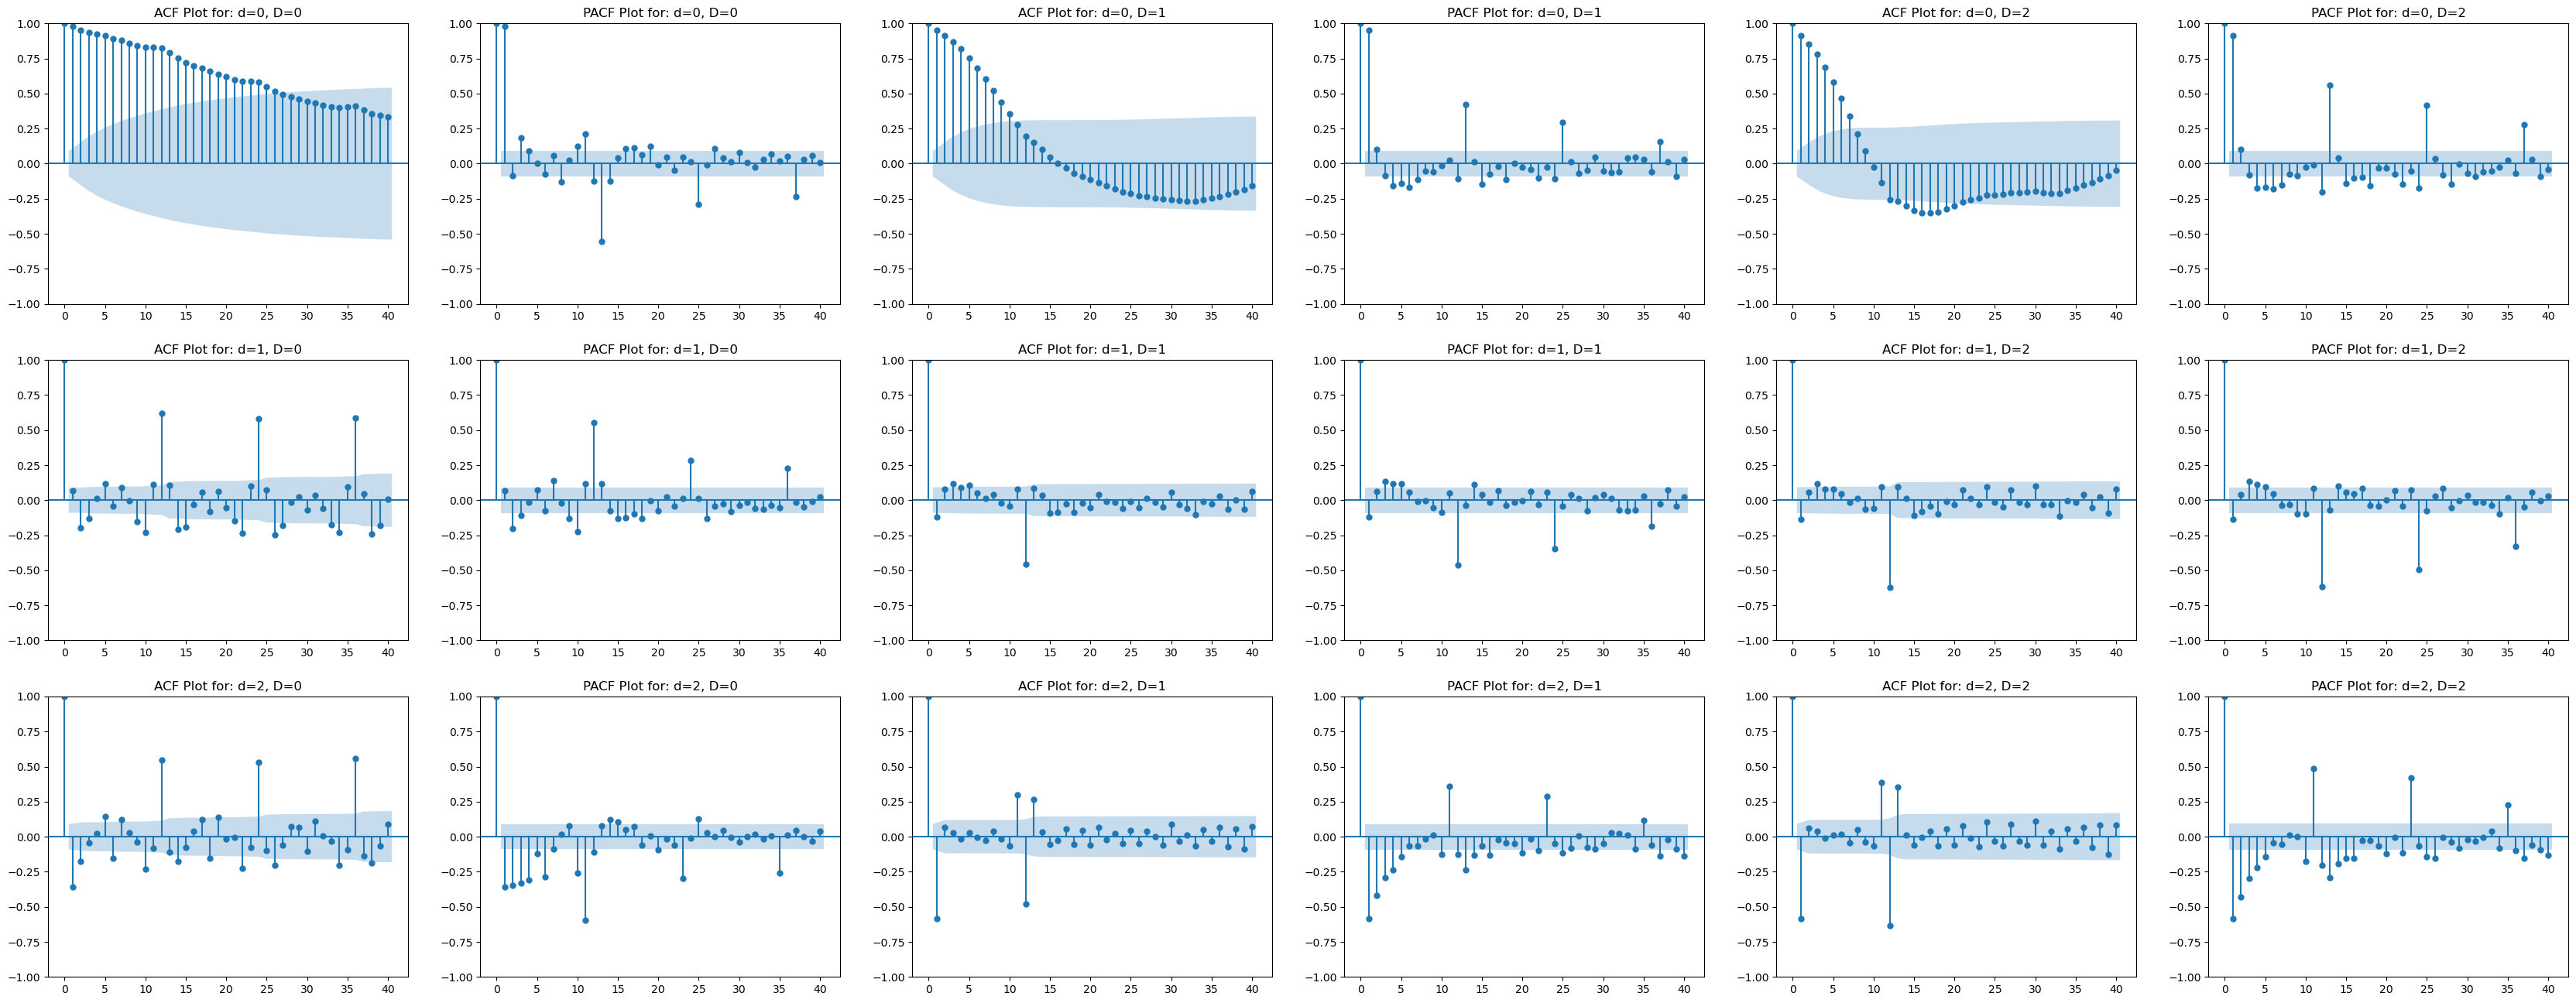

In [60]:
# Next we look at the ACF and PACF plot to determine:
##    (a) whether the data is appropriately stationary, and
##    (b) candidates for Auto-Regression (AR) and Moving Average (MA)
plt.figure(figsize=(42,16))
nrows, ncols = 3, 6

for i, diff_plot in enumerate([[0, 0],
                               [0, 1],
                               [0, 2],
                               [1, 0],
                               [1, 1],
                               [1, 2],
                               [2, 0],
                               [2, 1],
                               [2, 2]
                              ]):
    df_diff = df_ts.copy()
    
    for base_diff in range(diff_plot[0]):
        df_diff -= df_diff.shift(1)
        
    for seas_diff in range(diff_plot[1]):
        df_diff -= df_diff.shift(12)

    sm.graphics.tsaplots.plot_acf(df_diff.dropna(),
                                  ax=plt.subplot(nrows, ncols, 2*i+1), lags=40,
                                  title=f'ACF Plot for: d={diff_plot[0]}, D={diff_plot[1]}'
                                 )
    sm.graphics.tsaplots.plot_pacf(df_diff.dropna(), method='ywm', lags=40,
                                   ax=plt.subplot(nrows, ncols, 2*i+2),
                                   title=f'PACF Plot for: d={diff_plot[0]}, D={diff_plot[1]}'
                                  )
plt.show()

Based on the ACF and PACF plots, at least first order differencing is required (i.e. $d > 0$) and likely seasonal differencing too ($D > 0$).

**Diffrencing**

However, there isn't a large improvement after first order differencing, while not much improvement after $D = 1$. Therefore, exploring:
- ${d}\in\{1, 2\}$
- ${D}\in\{0, 1\}$

**Moving Avereage**

From the stationary ACF plots, there are various potential points where the values stop being significant - sometimes 1, 2, 3, 5, 7. For seasonality, the significant figure drops after the first seasonal period. Therefore, exploring:
- ${q}\in\{1, 2, 3, 5, 7\}$ **TODO: May try 4**
- ${Q}\in\{0, 1\}$ - **TODO: May try 2 with best values**

**Auto-Regression**

From the stationary PACF plots, the values fall slowly often to 5 or 7. For seasonality, there is a gradual fall each seasonal period. Therefore, exploring:
- ${p}\in\{1, 3, 5, 7\}$
- ${P}\in\{0, 1, 2, 3\}$

In [63]:
SARIMA_params = {
    'p': [1,3,5,7],
    'd': [1,2],
    'q': [1,2,3,5,7],
    'P': [0,1,2,3],
    'D': [0,1],
    'Q': [0,1]
}

print('Total no. of cominations for testing:', np.product([len(SARIMA_params[p]) for p in SARIMA_params]))

Total no. of cominations for testing: 640


We apply a grid search over the search space to find the optimal combination for the training set. *Note: This takes a significant amount of time - results are stored in `SARIMA_Grid_Search.csv`.*

In [64]:
# Conduct a Grid-Search to find the optimal hyper-params for SARIMA based on our candidates
get_results_quick = True
if get_results_quick:
    SARIMA_results = pd.read_csv('log_results/SARIMA_Grid_Search.csv', index_col=0)
    print(f'Best Parameters are: {SARIMA_results.index[np.argmin(SARIMA_results)]} with RMSE = {SARIMA_results.min().item():.4f}')
else:
    start_time = time.time()

    # Define a SARIMAX model testing all values
    store_results = dict()
    best_params = [0, 0, 0, 0, 0, 0]
    best_rmse = 1_000
    for P_trial in SARIMA_params['P']:
        print(f'######### --------- New P Values {P_trial}: Prev took {time.time()-start_time} seconds ---------- #################')
        start_time = time.time()
        for Q_trial in SARIMA_params['Q']:
            for D_trial in SARIMA_params['D']:
                for p_trial in SARIMA_params['p']:
                    for q_trial in SARIMA_params['q']:
                        for d_trial in SARIMA_params['d']:
                            order = (p_trial, d_trial, q_trial)
                            seasonal_order = (P_trial, D_trial, Q_trial, 12)
                            model = sm.tsa.statespace.sarimax.SARIMAX(ts_train, 
                                                                      order = order,
                                                                      seasonal_order = seasonal_order,
                                                                      enforce_stationarity = False,
                                                                      enforce_invertibility = False,
                                                                     ).fit()


                            forecasts = model.forecast(ts_val.shape[0]) # predict N steps into the future
                            error = RMSE(ts_val, forecasts)
                            print(f'Fit ({p_trial, d_trial, q_trial})({P_trial, D_trial, Q_trial}): RMSE = {error:.4f}')
                            store_results[str(order)+str(seasonal_order)] = error

                            if error < best_rmse:
                                best_rmse = error
                                best_params = [order,
                                               seasonal_order
                                              ]
                                print('New Best Score!')
                                
    SARIMA_results = pd.DataFrame(data=store_results.values(), index=store_results.keys(), columns = ['RMSE'])
    SARIMA_results.to_csv('SARIMA_Grid_Search.csv')
    print(f'Best Parameters are: {SARIMA_results.index[np.argmin(SARIMA_results)]} with RMSE = {SARIMA_results.min().item():.4f}')

Best Parameters are: (1, 2, 7)(0, 1, 2, 12) with RMSE = 0.1515


In [65]:
# However, due to the potential for overfitting on the training set (there are many results with similarly low error),
# we observe a combination of effective hyper-parameters and re-test these in Section 4.
SARIMA_results[SARIMA_results['RMSE']<0.16]

,RMSE
"(1, 2, 7)(0, 1, 1, 12)",0.154376
"(3, 1, 5)(0, 1, 1, 12)",0.158734
"(5, 2, 2)(0, 1, 1, 12)",0.154212
"(5, 2, 4)(0, 1, 1, 12)",0.157316
"(7, 2, 1)(0, 1, 1, 12)",0.152692
"(7, 2, 2)(0, 1, 1, 12)",0.154205
"(7, 2, 3)(0, 1, 1, 12)",0.154063
"(1, 2, 7)(0, 1, 2, 12)",0.151452
"(2, 2, 7)(0, 1, 2, 12)",0.157922
"(3, 2, 7)(0, 1, 2, 12)",0.153291


In [66]:
# Selecting a variety of top-performing models for hyper-param optimisation
SARIMA_models = dict()
SARIMA_models['(1, 2, 7)(0, 1, 1, 12)'] = [(1, 2, 7), (0, 1, 1, 12)]
SARIMA_models['(3, 1, 5)(0, 1, 1, 12)'] = [(3, 1, 5), (0, 1, 1, 12)]
SARIMA_models['(5, 2, 2)(0, 1, 1, 12)'] = [(5, 2, 2), (0, 1, 1, 12)]
SARIMA_models['(7, 2, 3)(0, 1, 1, 12)'] = [(7, 2, 3), (0, 1, 1, 12)]
SARIMA_models['(1, 2, 7)(1, 0, 2, 12)'] = [(1, 2, 7), (1, 0, 2, 12)]
SARIMA_models['(5, 2, 1)(1, 1, 1, 12)'] = [(5, 2, 1), (1, 1, 1, 12)]
SARIMA_models['(5, 1, 2)(1, 1, 2, 12)'] = [(5, 1, 2), (1, 1, 2, 12)]
SARIMA_models['(7, 2, 1)(2, 1, 1, 12)'] = [(7, 2, 1), (2, 1, 1, 12)]
SARIMA_models['(5, 2, 4)(3, 1, 0, 12)'] = [(5, 2, 4), (3, 1, 0, 12)]

Given the no. of combinations, grid search across all possibilities is too much. We will refine this to a smaller set for evaluation. Additionally, we can use the statsmodels package to find an appropriate ARMA order using AIC or BIC.

#### 3.2.3 Seasonal ARIMA

In [67]:
# We use Auto-ARIMA first to find optimal values, then review a limited no. of alternatives
## This is to massively reduce the search space to find candidates for cross-validation scoring/evaluation

auto_ARIMA = pm.auto_arima(ts_train, seasonal=True, m=12, suppress_warnings=True,
                           max_p = max(SARIMA_params['p']), max_q = max(SARIMA_params['q']),
                           max_d = max(SARIMA_params['d']), max_D = max(SARIMA_params['D']),
                           max_P = max(SARIMA_params['P']), max_Q = max(SARIMA_params['Q']),
                          )

print('Hyper-parameters based on Auto ARIMA:')
print(f'ARIMA(p,d,q) = {auto_ARIMA.order}')
print(f'SARIMA(P,D,Q) = {auto_ARIMA.seasonal_order}')

Hyper-parameters based on Auto ARIMA:
ARIMA(p,d,q) = (2, 1, 2)
SARIMA(P,D,Q) = (1, 0, 1, 12)


In [68]:
y_fitted = auto_ARIMA.predict_in_sample(start=13, end=len(ts_train)-1)
y_preds = auto_ARIMA.predict(len(ts_val))

print('-----------------------')
print('   Scoring Auto-ARIMA  ')
print('-----------------------')
print(f'RMSE on training set  : {RMSE(ts_train[13:], y_fitted):.4f}')
print(f'RMSE on validation set: {RMSE(ts_val, y_preds):.4f}')
print('-----------------------')

-----------------------
   Scoring Auto-ARIMA  
-----------------------
RMSE on training set  : 0.1881
RMSE on validation set: 0.1793
-----------------------


In [69]:
for order, seasonal_order in SARIMA_models.values():
    SARIMA_model = sm.tsa.statespace.sarimax.SARIMAX(ts_train, 
                                                     order = order,
                                                     seasonal_order = seasonal_order,
                                                     freq='MS'
                                                    ).fit()
    
    y_fitted = SARIMA_model.predict(start=ts_train.index[0], end=ts_train.index[-1])
    y_preds = SARIMA_model.forecast(len(ts_val))
    
    
    print('-----------------------')
    print(f' Scoring S-ARIMA{order}{seasonal_order} ')
    print('-----------------------')
    print(f'RMSE on training set  : {RMSE(ts_train, y_fitted):.4f}')
    print(f'RMSE on validation set: {RMSE(ts_val, y_preds):.4f}')
    print('-----------------------')   

-----------------------
 Scoring S-ARIMA(1, 2, 7)(0, 1, 1, 12) 
-----------------------
RMSE on training set  : 0.3316
RMSE on validation set: 0.1718
-----------------------


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-----------------------
 Scoring S-ARIMA(3, 1, 5)(0, 1, 1, 12) 
-----------------------
RMSE on training set  : 0.2947
RMSE on validation set: 0.1816
-----------------------


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-----------------------
 Scoring S-ARIMA(5, 2, 2)(0, 1, 1, 12) 
-----------------------
RMSE on training set  : 0.3320
RMSE on validation set: 0.2266
-----------------------


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-----------------------
 Scoring S-ARIMA(7, 2, 3)(0, 1, 1, 12) 
-----------------------
RMSE on training set  : 0.3310
RMSE on validation set: 0.1624
-----------------------


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-----------------------
 Scoring S-ARIMA(1, 2, 7)(1, 0, 2, 12) 
-----------------------
RMSE on training set  : 0.3013
RMSE on validation set: 0.1583
-----------------------


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-----------------------
 Scoring S-ARIMA(5, 2, 1)(1, 1, 1, 12) 
-----------------------
RMSE on training set  : 0.3314
RMSE on validation set: 0.1611
-----------------------


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-----------------------
 Scoring S-ARIMA(5, 1, 2)(1, 1, 2, 12) 
-----------------------
RMSE on training set  : 0.2951
RMSE on validation set: 0.1625
-----------------------


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-----------------------
 Scoring S-ARIMA(7, 2, 1)(2, 1, 1, 12) 
-----------------------
RMSE on training set  : 0.3309
RMSE on validation set: 0.1704
-----------------------


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-----------------------
 Scoring S-ARIMA(5, 2, 4)(3, 1, 0, 12) 
-----------------------
RMSE on training set  : 0.3335
RMSE on validation set: 0.2046
-----------------------


<a id="3.3"></a>
### 3.3 Neural Networks
- Autoregression Network
- Recurrent Neural Network
    - Hyper-parameter Optimisation

[Return to top](#ToC)

#### 3.3.1 Autoregression Neural Network

In [70]:
# Set parameters for our network
time_window = 24

scaler = MinMaxScaler(feature_range=(0, 1))


scaler.fit(ts_train)
ts_train_scaled = scaler.transform(ts_train)
ts_val_scaled = scaler.transform(ts_val)

train_size = len(ts_train)-time_window
val_size = len(ts_val)-time_window

In [71]:
X_train, y_train = [], []
X_train_scaled, y_train_scaled = [], []

# Training data
for i in range(time_window, len(ts_train)):
    X_train.append(ts_train.iloc[i-time_window:i].values)
    X_train_scaled.append(ts_train_scaled[i-time_window:i])
    y_train.append(ts_train.iloc[i].values)
    y_train_scaled.append(ts_train_scaled[i])
    
# TODO: Data for 24-step predictions
    
X_train = np.array(X_train).reshape(-1,time_window)
X_train_scaled = np.array(X_train_scaled).reshape(-1,time_window)
y_train = np.array(y_train).reshape(-1,1)
y_train_scaled = np.array(y_train_scaled).reshape(-1,1)

X_train.shape, y_train.shape

((427, 24), (427, 1))

In [72]:
# Build the FFN model with 1 step ahead - Using dynamic prediction for forecasting
FFN_model = Sequential()
FFN_model.add(Dense(64, input_dim = time_window, activation='relu'))
FFN_model.add(Dense(64, input_dim = time_window, activation='relu'))
FFN_model.add(Dense(1))
FFN_model.compile(loss='mean_squared_error', optimizer='adam')
FFN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1600      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,825
Trainable params: 5,825
Non-trainable params: 0
_________________________________________________________________


In [74]:
FFN_model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=20 , verbose=0) # Increase to 500 later

In [75]:
y_fitted = scaler.inverse_transform(FFN_model.predict(X_train_scaled))

# For 24 step ahead, use next prediction as the input for the next time step
X_val_scaled = ts_train_scaled[-time_window:].reshape(-1,time_window)
y_preds_scaled = []
for step in range(time_window):
    next_pred = FFN_model.predict(X_val_scaled, verbose=0)
    y_preds_scaled.append(next_pred)
    
    # Update X_val
    X_val_scaled = np.concatenate([X_val_scaled[:,1:], next_pred], axis=1)
    
y_preds = scaler.inverse_transform(np.array(y_preds_scaled).reshape(-1,1))

print('-----------------------')
print('  Scoring FFN Network  ')
print('-----------------------')
print(f'RMSE on training set  : {RMSE(ts_train[time_window:], y_fitted):.4f}')
print(f'RMSE on validation set: {RMSE(ts_val, y_preds):.4f}')
print('-----------------------')

14/14 [==============================] - 0s 769us/step
-----------------------
  Scoring FFN Network  
-----------------------
RMSE on training set  : 0.1528
RMSE on validation set: 0.2262
-----------------------


#### 3.3.2 Recurrent Neural Network

**NOTE:** Use np.expand_dims(next_pred, axis=2) to make it clearer what we are doing...

In [78]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
ts_train_scaled = scaler.fit_transform(ts_train)

In [79]:
len(ts_train)

451

In [88]:
time_window = 12
X_train, y_train = [], []
X_train_scaled, y_train_scaled = [], []

# Training data
for i in range(time_window, len(ts_train)):
    X_train_scaled.append(ts_train_scaled[i-time_window:i])
    y_train_scaled.append(ts_train_scaled[i])

# data dimension transform for Sequential RNN
X_train_scaled = np.array(X_train_scaled).reshape(-1,1,time_window)
y_train_scaled = np.array(y_train_scaled).reshape(-1,1)
    
print(y_train_scaled.shape)
print(X_train_scaled.shape)

(439, 1)
(439, 1, 12)


**Hyper-Parameter Tuning:** Activation Function

In [90]:
# Create initial model

# Result list
train_rmse =[]
val_rmse = [] 

#Activation function test
activation_func_list = ['LeakyReLU','relu','sigmoid','tanh'] 
for activation_func in activation_func_list:
    #score list
    trainScore_activation_list = []
    valScore_activation_list = []
    
    # Build the model for iteration
    tf.random.set_seed(51)
    RNN_model = Sequential()
    RNN_model.add(SimpleRNN(10, activation=activation_func)) # This is what we are tuning
    RNN_model.add(Dense(1))
    RNN_model.compile(optimizer='Nadam', loss='mse')
    RNN_model.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=10, verbose=0)
    
    y_fitted = scaler.inverse_transform(RNN_model.predict(X_train_scaled))
    
    # For validation, apply the next prediction as input for the next step
    X_val_scaled = ts_train_scaled[-time_window:].reshape(-1,1,time_window)
    y_preds_scaled = []
    for step in range(24):
        next_pred = RNN_model.predict(X_val_scaled, verbose=0)
        y_preds_scaled.append(next_pred)

        # Update X_val
        X_val_scaled = np.concatenate([X_val_scaled[:,:,1:], next_pred.reshape(1,1,1)], axis=2)
    y_preds = scaler.inverse_transform(np.array(y_preds_scaled).reshape(-1,1))
    
    train_score = RMSE(ts_train[time_window:], y_fitted)
    val_score = RMSE(ts_val, y_preds)
    train_rmse.append(train_score)
    val_rmse.append(val_score)
    print('-----------------------')
    print('  Scoring RNN Network  ')
    print(f'\tActivation: {activation_func}')
    print('-----------------------')
    print(f'RMSE on training set  : {train_score:.4f}')
    print(f'RMSE on validation set: {val_score:.4f}')
    print('-----------------------')

print('########################')
print('Results:')
results = []
for i, (x, y) in enumerate(zip(train_rmse, val_rmse)):
    results.append([activation_func_list[i], x, y])
    
display(pd.DataFrame(results, columns=['Activation Func', 'Train RMSE', 'Val RMSE']))

14/14 [==============================] - 0s 910us/step
-----------------------
  Scoring RNN Network  
	Activation: LeakyReLU
-----------------------
RMSE on training set  : 0.3654
RMSE on validation set: 0.3968
-----------------------
14/14 [==============================] - 0s 923us/step
-----------------------
  Scoring RNN Network  
	Activation: relu
-----------------------
RMSE on training set  : 0.4165
RMSE on validation set: 0.5795
-----------------------
14/14 [==============================] - 0s 999us/step
-----------------------
  Scoring RNN Network  
	Activation: sigmoid
-----------------------
RMSE on training set  : 0.6338
RMSE on validation set: 0.9178
-----------------------
14/14 [==============================] - 0s 1000us/step
-----------------------
  Scoring RNN Network  
	Activation: tanh
-----------------------
RMSE on training set  : 0.5472
RMSE on validation set: 0.5317
-----------------------
########################
Results:


,Activation Func,Train RMSE,Val RMSE
0,LeakyReLU,0.365431,0.396752
1,relu,0.416512,0.579484
2,sigmoid,0.633793,0.917790
3,tanh,0.547238,0.531710


**Hyper-Parameter Tuning:** Optimizer

In [91]:
optimizer_func_list = ['sgd','adam','Nadam','RMSprop']
# Result list
train_rmse =[]
val_rmse = [] 

for optimizer_func in optimizer_func_list:
    
    # Build the model for iteration
    tf.random.set_seed(51)
    RNN_model = Sequential()
    RNN_model.add(SimpleRNN(10, activation='LeakyReLU'))
    RNN_model.add(Dense(1))
    RNN_model.compile(optimizer=optimizer_func, loss='mse') # This is what we are tuning
    RNN_model.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=10, verbose=0)
    
    y_fitted = scaler.inverse_transform(RNN_model.predict(X_train_scaled))
    
    # For validation, apply the next prediction as input for the next step
    X_val_scaled = ts_train_scaled[-time_window:].reshape(-1,1,time_window)
    y_preds_scaled = []
    for step in range(24):
        next_pred = RNN_model.predict(X_val_scaled, verbose=0)
        y_preds_scaled.append(next_pred)

        # Update X_val
        X_val_scaled = np.concatenate([X_val_scaled[:,:,1:], next_pred.reshape(1,1,1)], axis=2)
    y_preds = scaler.inverse_transform(np.array(y_preds_scaled).reshape(-1,1))
    
    train_score = RMSE(ts_train[time_window:], y_fitted)
    val_score = RMSE(ts_val, y_preds)
    train_rmse.append(train_score)
    val_rmse.append(val_score)
    print('-----------------------')
    print('  Scoring RNN Network  ')
    print(f'\tOptimizer: {optimizer_func}')
    print('-----------------------')
    print(f'RMSE on training set  : {train_score:.4f}')
    print(f'RMSE on validation set: {val_score:.4f}')
    print('-----------------------')

print('########################')
print('Results:')
results = []
for i, (x, y) in enumerate(zip(train_rmse, val_rmse)):
    results.append([optimizer_func_list[i], x, y])
    
display(pd.DataFrame(results, columns=['Optimization Func', 'Train RMSE', 'Val RMSE']))

14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring RNN Network  
	Optimizer: sgd
-----------------------
RMSE on training set  : 0.5651
RMSE on validation set: 0.7515
-----------------------
14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring RNN Network  
	Optimizer: adam
-----------------------
RMSE on training set  : 0.5057
RMSE on validation set: 0.6411
-----------------------
14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring RNN Network  
	Optimizer: Nadam
-----------------------
RMSE on training set  : 0.3881
RMSE on validation set: 0.3808
-----------------------
14/14 [==============================] - 0s 942us/step
-----------------------
  Scoring RNN Network  
	Optimizer: RMSprop
-----------------------
RMSE on training set  : 0.2929
RMSE on validation set: 1.0092
-----------------------
########################
Results:


,Optimization Func,Train RMSE,Val RMSE
0,sgd,0.565059,0.751530
1,adam,0.505663,0.641115
2,Nadam,0.388109,0.380787
3,RMSprop,0.292886,1.009154


**Hyper-Parameter Tuning:** Batch Size

In [92]:
batch_num_list = [1, 12,24,144,288]

# Result list
train_rmse =[]
val_rmse = [] 

for batch_num in batch_num_list:
    
    # Build the model for iteration
    tf.random.set_seed(51)
    RNN_model = Sequential()
    RNN_model.add(SimpleRNN(100, activation='LeakyReLU'))
    RNN_model.add(Dense(1))
    RNN_model.compile(optimizer='RMSprop', loss='mse') # This is what we are tuning
    RNN_model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=batch_num, verbose=0)
    
    y_fitted = scaler.inverse_transform(RNN_model.predict(X_train_scaled))
    
    # For validation, apply the next prediction as input for the next step
    X_val_scaled = ts_train_scaled[-time_window:].reshape(-1,1,time_window)
    y_preds_scaled = []
    for step in range(24):
        next_pred = RNN_model.predict(X_val_scaled, verbose=0)
        y_preds_scaled.append(next_pred)

        # Update X_val
        X_val_scaled = np.concatenate([X_val_scaled[:,:,1:], next_pred.reshape(1,1,1)], axis=2)
    y_preds = scaler.inverse_transform(np.array(y_preds_scaled).reshape(-1,1))
    
    train_score = RMSE(ts_train[time_window:], y_fitted)
    val_score = RMSE(ts_val, y_preds)
    train_rmse.append(train_score)
    val_rmse.append(val_score)
    print('-----------------------')
    print('  Scoring RNN Network  ')
    print(f'\tBatch Size: {batch_num}')
    print('-----------------------')
    print(f'RMSE on training set  : {train_score:.4f}')
    print(f'RMSE on validation set: {val_score:.4f}')
    print('-----------------------')

print('########################')
print('Results:')
results = []
for i, (x, y) in enumerate(zip(train_rmse, val_rmse)):
    results.append([batch_num_list[i], x, y])
    
display(pd.DataFrame(results, columns=['Batch No.', 'Train RMSE', 'Val RMSE']))

14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring RNN Network  
	Batch Size: 1
-----------------------
RMSE on training set  : 0.3476
RMSE on validation set: 0.6488
-----------------------
14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring RNN Network  
	Batch Size: 12
-----------------------
RMSE on training set  : 0.2543
RMSE on validation set: 0.3484
-----------------------
14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring RNN Network  
	Batch Size: 24
-----------------------
RMSE on training set  : 0.3824
RMSE on validation set: 3.5280
-----------------------
14/14 [==============================] - 0s 923us/step
-----------------------
  Scoring RNN Network  
	Batch Size: 144
-----------------------
RMSE on training set  : 0.3190
RMSE on validation set: 0.3116
-----------------------
14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring RNN

,Batch No.,Train RMSE,Val RMSE
0,1,0.347554,0.648750
1,12,0.254336,0.348403
2,24,0.382380,3.528014
3,144,0.318957,0.311598
4,288,0.476550,0.533952


The error is lowest with smaller batch sizes. The plot below illustrates this more clearly.

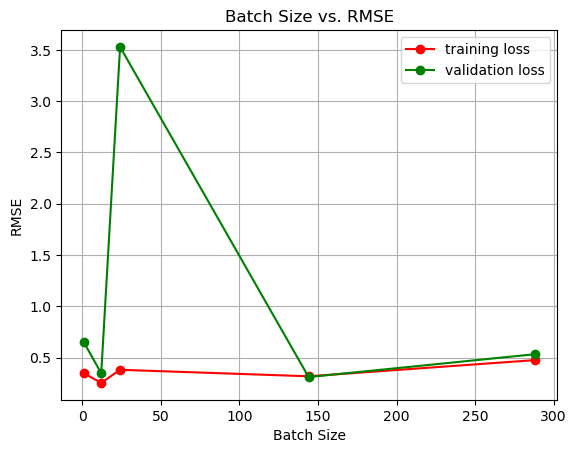

In [93]:
# Plot loss for different batch sizes
plt.plot(figsize=(10,6))
plt.title('Batch Size vs. RMSE')
plt.xlabel('Batch Size')
plt.ylabel('RMSE')
plt.grid(True)
plt.plot(batch_num_list, train_rmse, 'r-o', label='training loss') 
plt.plot(batch_num_list, val_rmse, 'g-o', label='validation loss')

plt.legend()
plt.show()

In [94]:
epoch_list   = [5,10,20,50,100]

# Result list
train_rmse =[]
val_rmse = [] 

for epoch in epoch_list:
    
    # Build the model for iteration
    tf.random.set_seed(51)
    RNN_model = Sequential()
    RNN_model.add(SimpleRNN(100, activation='LeakyReLU'))
    RNN_model.add(Dense(1))
    RNN_model.compile(optimizer='RMSprop', loss='mse')
    RNN_model.fit(X_train_scaled, y_train_scaled, epochs=epoch, batch_size=12, verbose=0) # This is what we are tuning
    
    y_fitted = scaler.inverse_transform(RNN_model.predict(X_train_scaled))
    
    # For validation, apply the next prediction as input for the next step
    X_val_scaled = ts_train_scaled[-time_window:].reshape(-1,1,time_window)
    y_preds_scaled = []
    for step in range(24):
        next_pred = RNN_model.predict(X_val_scaled, verbose=0)
        y_preds_scaled.append(next_pred)

        # Update X_val
        X_val_scaled = np.concatenate([X_val_scaled[:,:,1:], next_pred.reshape(1,1,1)], axis=2)
    y_preds = scaler.inverse_transform(np.array(y_preds_scaled).reshape(-1,1))
    
    train_score = RMSE(ts_train[time_window:], y_fitted)
    val_score = RMSE(ts_val, y_preds)
    train_rmse.append(train_score)
    val_rmse.append(val_score)
    print('-----------------------')
    print('  Scoring RNN Network  ')
    print(f'\tEpoch Size: {epoch}')
    print('-----------------------')
    print(f'RMSE on training set  : {train_score:.4f}')
    print(f'RMSE on validation set: {val_score:.4f}')
    print('-----------------------')

print('########################')
print('Results:')
results = []
for i, (x, y) in enumerate(zip(train_rmse, val_rmse)):
    results.append([epoch_list[i], x, y])
    
display(pd.DataFrame(results, columns=['Epochs', 'Train RMSE', 'Val RMSE']))

14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring RNN Network  
	Epoch Size: 5
-----------------------
RMSE on training set  : 0.5663
RMSE on validation set: 3.9644
-----------------------
14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring RNN Network  
	Epoch Size: 10
-----------------------
RMSE on training set  : 0.3238
RMSE on validation set: 0.5091
-----------------------
14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring RNN Network  
	Epoch Size: 20
-----------------------
RMSE on training set  : 0.4564
RMSE on validation set: 4.4374
-----------------------
14/14 [==============================] - 0s 932us/step
-----------------------
  Scoring RNN Network  
	Epoch Size: 50
-----------------------
RMSE on training set  : 0.2587
RMSE on validation set: 0.3364
-----------------------
14/14 [==============================] - 0s 1ms/step
-----------------------
  Scoring RNN 

,Epochs,Train RMSE,Val RMSE
0,5,0.566330,3.964365
1,10,0.323782,0.509146
2,20,0.456429,4.437419
3,50,0.258715,0.336419
4,100,0.286507,0.507188


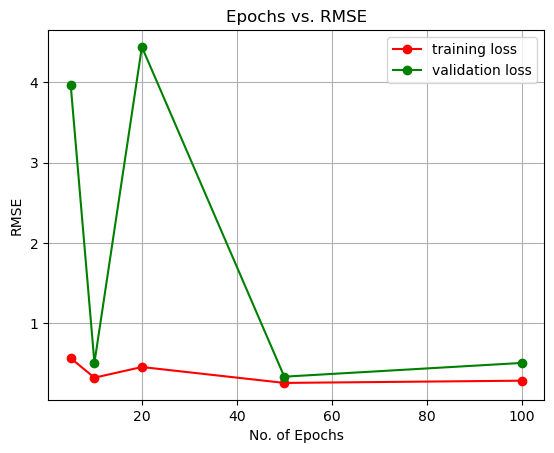

In [95]:
# Plot loss for different epochs
plt.plot(figsize=(10,6))
plt.title('Epochs vs. RMSE')
plt.xlabel('No. of Epochs')
plt.ylabel('RMSE')
plt.grid(True)
plt.plot(epoch_list, train_rmse, 'r-o', label='training loss') 
plt.plot(epoch_list, val_rmse, 'g-o', label='validation loss')

plt.legend()
plt.show()

#### 3.3.3 Convolutional Neural Network ??

In [ ]:
## TODO: Discussion inclusion of CNN model (not part of the 3 for reporting)

<a id="4.0"></a>
### 4.0 Model Training & Scoring
- Creating Time Series CV Folds
- Fit and Forecast Models
- Results

[Return to top](#ToC)

#### 4.1 Creating Time Series CV Folds

In [96]:
# Using the Time Series Cross-Validation Splits from our utilities
# This allows us to customize the "stepping size" to take more recent values

train_folds, val_folds = ts_cross_val_split(df_ts, splits=5, forecast_window=24, step=12)

print('Original training data size:', len(df_ts))
print('Size of each cross validation split:')

for n in range(5):
    print(train_folds[n].shape, val_folds[n].shape)

Created 5 splits for cross-validation. Expanding window = 12 months | Forecast window = 24 months
Original training data size: 475
Size of each cross validation split:
(403, 1) (24, 1)
(415, 1) (24, 1)
(427, 1) (24, 1)
(439, 1) (24, 1)
(451, 1) (24, 1)


Plotting the folds to observe the expanding window and what each fold's validation set looks like.

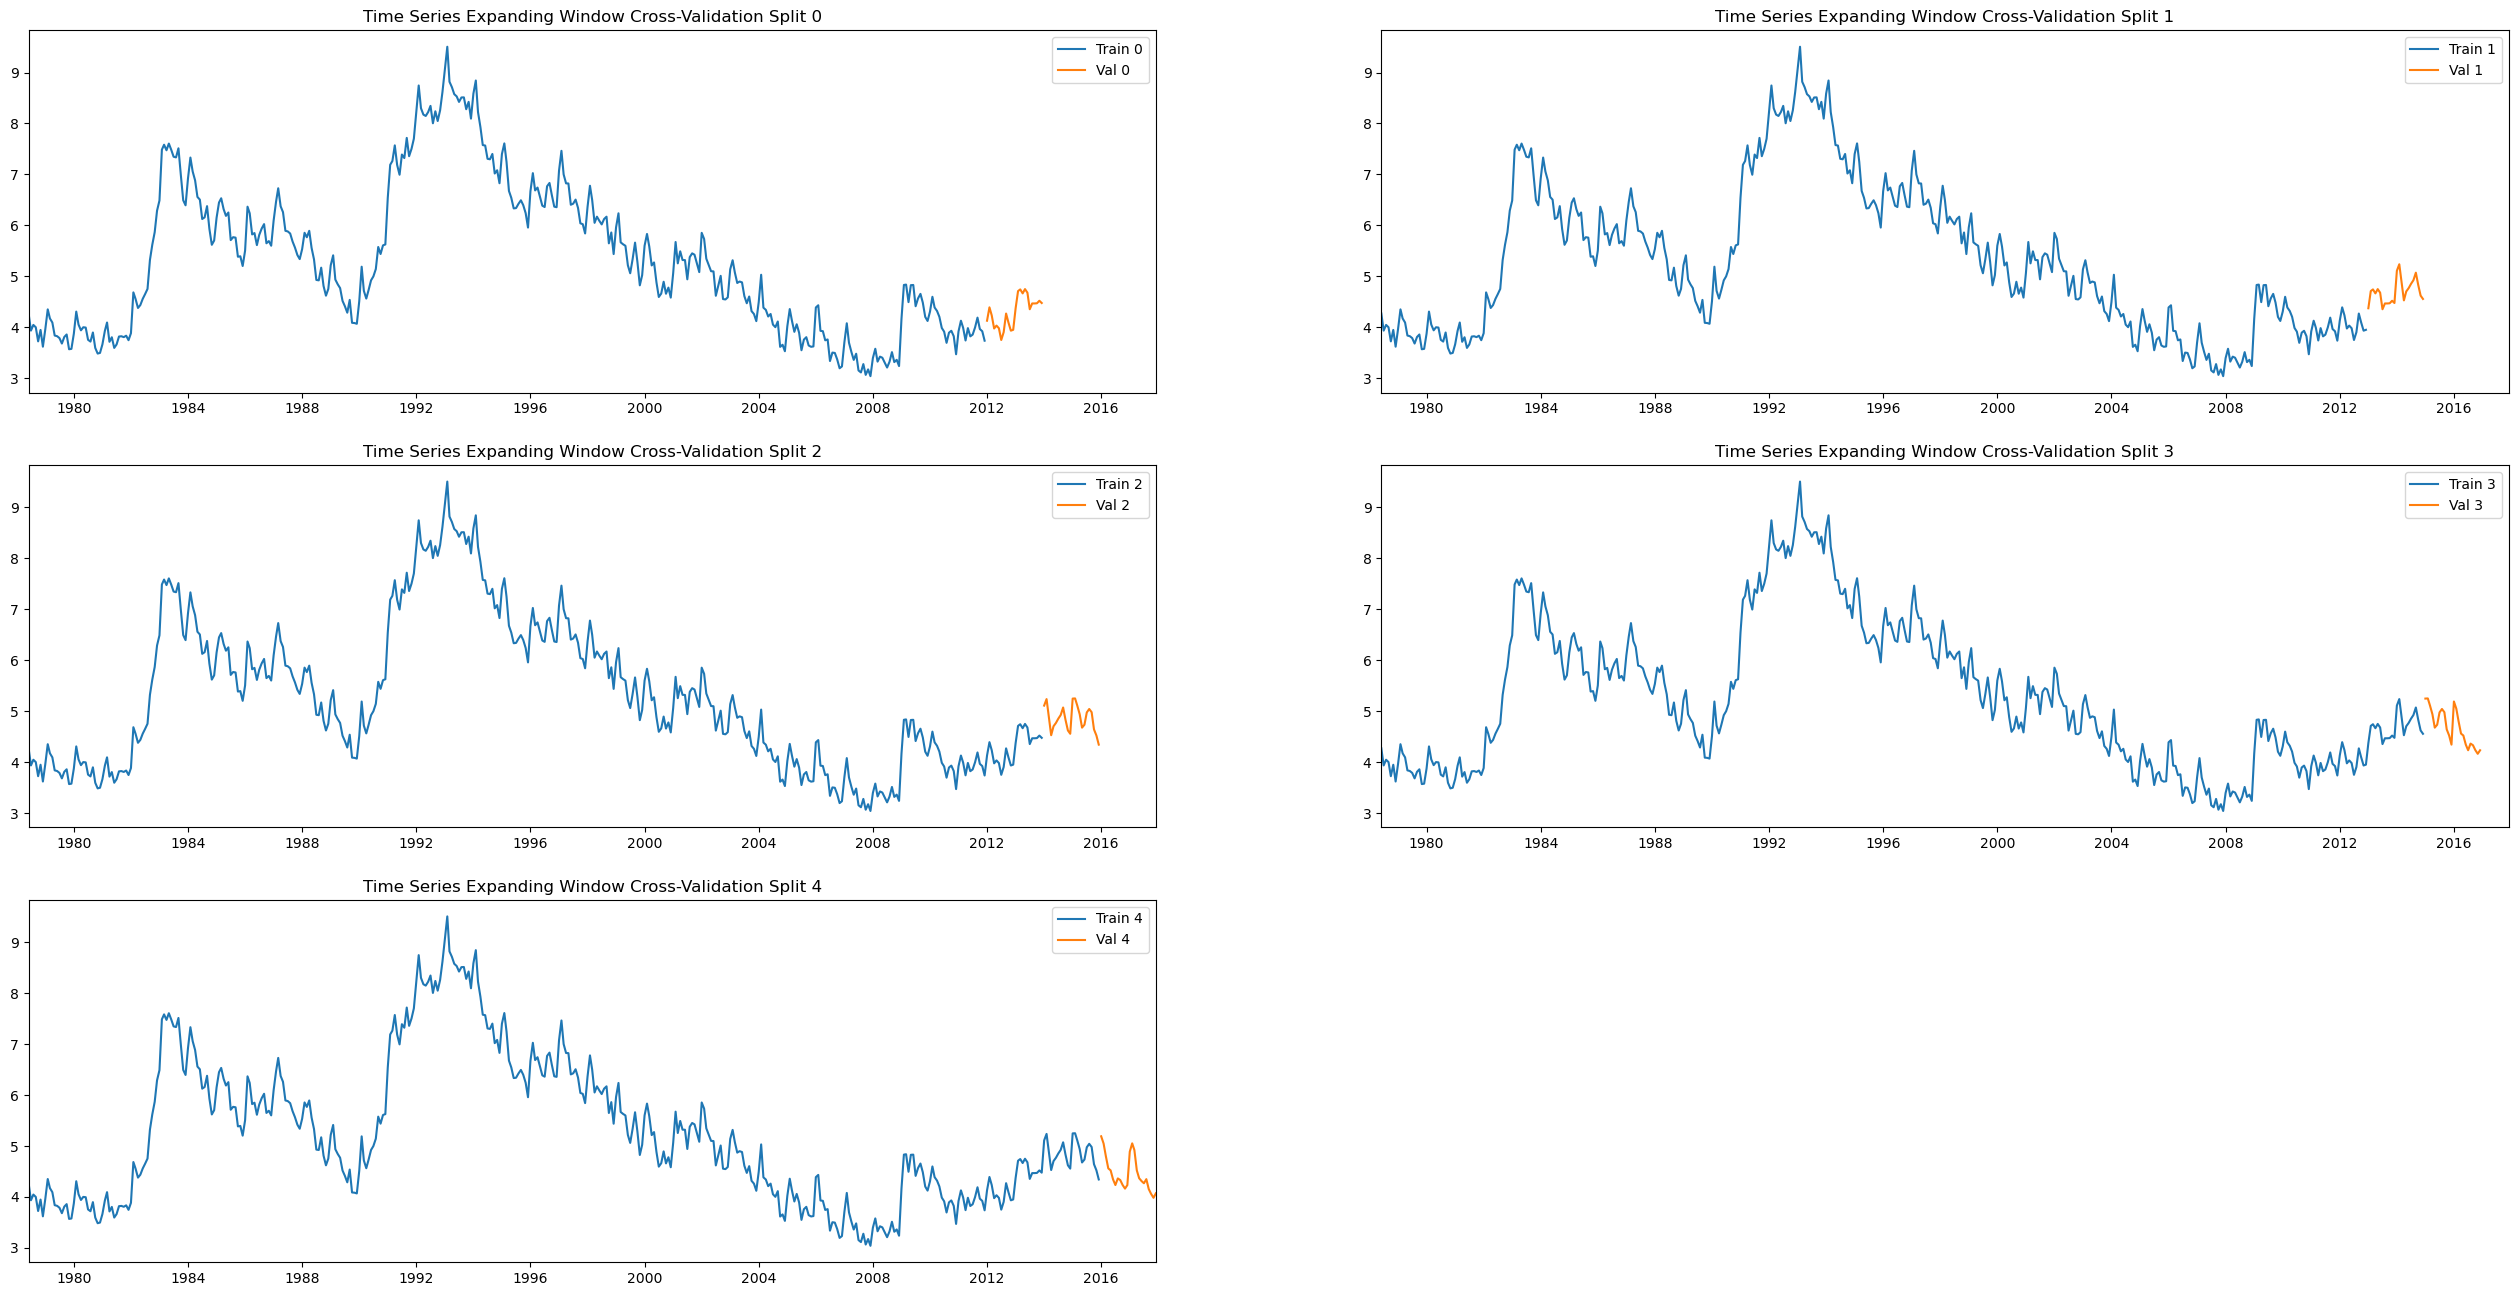

In [97]:
# Plot the train-val splits
plt.figure(figsize=(32,16))
start = min(df_ts.index)
end = max(df_ts.index)

for i, (df_train, df_val) in enumerate(zip(train_folds, val_folds)):
    ax = plt.subplot(3, 2, i + 1)
    
    ax.set_title(f'Time Series Expanding Window Cross-Validation Split {i}')
    ax.set_xlim(start, end)
    ax.plot(df_train, label=f'Train {i}')
    ax.plot(df_val, label=f'Val {i}')
    ax.legend()

plt.show()

#### 4.2 Define Models

Creating baseline models to set the benchmark for model performance.

In [98]:
# Use the SimpleModel class developed in our utilities module
avg_model = SimpleModel('average')
naive_model = SimpleModel('naive')
drift_model = SimpleModel('drift')
growth_model = SimpleModel('growth')

baseline_models = {'average': avg_model, 'naive': naive_model, 'drift': drift_model, 'growth': growth_model}

In [99]:
# Forecast ahead amount
forecast_window = 24

# Candidate SARIMAX parameters
print('-----------------------')
print('Candidate S-ARIMA Models for Cross-Validation:')
print(SARIMA_models)

# Prepare hyper-params for NN models
print('-----------------------')
scaler = MinMaxScaler(feature_range=(0, 1))
time_window = 24

## Autoregressive NN model
tf.random.set_seed(51)
FFN_model = Sequential()
FFN_model.add(Dense(64, input_dim = time_window, activation='relu'))
FFN_model.add(Dense(64, input_dim = time_window, activation='relu'))
FFN_model.add(Dense(1))
FFN_model.compile(loss='mean_squared_error', optimizer='adam')
FFN_model.summary()

## Recurrent NN model
tf.random.set_seed(51)
RNN_model = Sequential()
RNN_model.add(SimpleRNN(100, activation='LeakyReLU'))
RNN_model.add(Dense(1))
RNN_model.compile(optimizer='RMSprop', loss='mse')
#RNN_model.summary()

-----------------------
Candidate S-ARIMA Models for Cross-Validation:
{'(1, 2, 7)(0, 1, 1, 12)': [(1, 2, 7), (0, 1, 1, 12)], '(3, 1, 5)(0, 1, 1, 12)': [(3, 1, 5), (0, 1, 1, 12)], '(5, 2, 2)(0, 1, 1, 12)': [(5, 2, 2), (0, 1, 1, 12)], '(7, 2, 3)(0, 1, 1, 12)': [(7, 2, 3), (0, 1, 1, 12)], '(1, 2, 7)(1, 0, 2, 12)': [(1, 2, 7), (1, 0, 2, 12)], '(5, 2, 1)(1, 1, 1, 12)': [(5, 2, 1), (1, 1, 1, 12)], '(5, 1, 2)(1, 1, 2, 12)': [(5, 1, 2), (1, 1, 2, 12)], '(7, 2, 1)(2, 1, 1, 12)': [(7, 2, 1), (2, 1, 1, 12)], '(5, 2, 4)(3, 1, 0, 12)': [(5, 2, 4), (3, 1, 0, 12)]}
-----------------------
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 64)                1600      
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 

In [100]:
import time
# Store results for cross-validation loop
cv_predictions = []
cv_results = []

for df_train, df_val in zip(train_folds, val_folds):
    fold_time = time.time()
    model_preds = dict()
    model_results = dict()
    
    # Fit and Forecast Baseline
    for model_key in baseline_models:
        baseline_models[model_key].fit(df_train)
        y_preds = baseline_models[model_key].predict(len(df_val))
        model_preds[model_key] = y_preds
        model_results[model_key] = RMSE(df_val, y_preds)
        
    # Fit and Forecast Holt-Winters
    for HW_seasonal in ['additive', 'multiplicative']:
        hw_model = ExponentialSmoothing(df_train, seasonal_periods=12, trend='add', seasonal=HW_seasonal).fit()
        y_preds = hw_model.forecast(len(df_val))
        model_preds['HW-'+HW_seasonal] = y_preds
        model_results['HW-'+HW_seasonal] = RMSE(df_val, y_preds)
        
    # Fit and Forecast Seasonal ARIMA
    for order, seasonal_order in SARIMA_models.values():
        SARIMA_model = sm.tsa.statespace.sarimax.SARIMAX(df_train, 
                                                         order = order,
                                                         seasonal_order = seasonal_order,
                                                         enforce_stationarity = False,
                                                         enforce_invertibility = False,
                                                ).fit()
        y_preds = SARIMA_model.forecast(len(df_val))
        model_preds['SARIMA'+str(order)+str(seasonal_order)] = y_preds
        model_results['SARIMA'+str(order)+str(seasonal_order)] = RMSE(df_val, y_preds)
        
    # Fit and Forecast Neural Nets
    ## Create training data
    train_scaled = scaler.fit_transform(df_train)
    X_scaled, y_scaled = [], []
    for i in range(time_window, len(df_train)):
        X_scaled.append(train_scaled[i-time_window:i])
        y_scaled.append(train_scaled[i])

    X_scaled = np.array(X_scaled).reshape(-1,time_window)
    y_scaled = np.array(y_scaled).reshape(-1,1)
    
    FFN_model.fit(X_scaled, y_scaled, epochs=50, batch_size=20, verbose=0)
    
    ## For 24 step ahead, use next prediction as the input for the next time step
    ## For FNN
    X_val_scaled = train_scaled[-time_window:].reshape(-1,time_window)
    y_preds_scaled = []
    for step in range(time_window):
        next_pred = FFN_model.predict(X_val_scaled, verbose=0)
        y_preds_scaled.append(next_pred)

        ## Update X_val
        X_val_scaled = np.concatenate([X_val_scaled[:,1:], next_pred], axis=1)
        
    y_preds = scaler.inverse_transform(np.array(y_preds_scaled).reshape(-1,1))
    model_preds['NN-Autoregressive'] = y_preds
    model_results['NN-Autoregressive'] = RMSE(df_val, y_preds)
    
    ## For RNN
    X_scaled = X_scaled.reshape(-1,1,time_window)
    RNN_model.fit(X_scaled, y_scaled, epochs=50, batch_size=12, verbose=0)
    
    X_val_scaled = train_scaled[-time_window:].reshape(-1,1,time_window)
    y_preds_scaled = []
    for step in range(time_window):
        next_pred = RNN_model.predict(X_val_scaled, verbose=0)
        y_preds_scaled.append(next_pred)

        ## Update X_val
        X_val_scaled = np.concatenate([X_val_scaled[:,:,1:], np.expand_dims(next_pred, axis=2)], axis=2) # RNN can grow
        
    y_preds = scaler.inverse_transform(np.array(y_preds_scaled).reshape(-1,1))
    model_preds['RNN'] = y_preds
    model_results['RNN'] = RMSE(df_val, y_preds)
    
    # Store results of cross-validation fold
    cv_predictions.append(model_preds)
    cv_results.append(model_results)
    print(f'Completed cross-validation fold in {time.time()-fold_time:.4f} seconds')

print(f'All folds complete. Total Time = {(time.time()-fold_time)/60:.4f} minutes')    

C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: M

Completed cross-validation fold in 74.6264 seconds


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: M

Completed cross-validation fold in 70.2436 seconds


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: M

Completed cross-validation fold in 72.1922 seconds


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: M

Completed cross-validation fold in 75.2274 seconds


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: M

Completed cross-validation fold in 82.9891 seconds
All folds complete. Total Time = 1.3832 minutes


Evaluate the performance on each fold, and the overall average below. As this is an expanding window cross-validation, we expect forecasts to improve with more data and will give more weight to models that perform better on later folds.

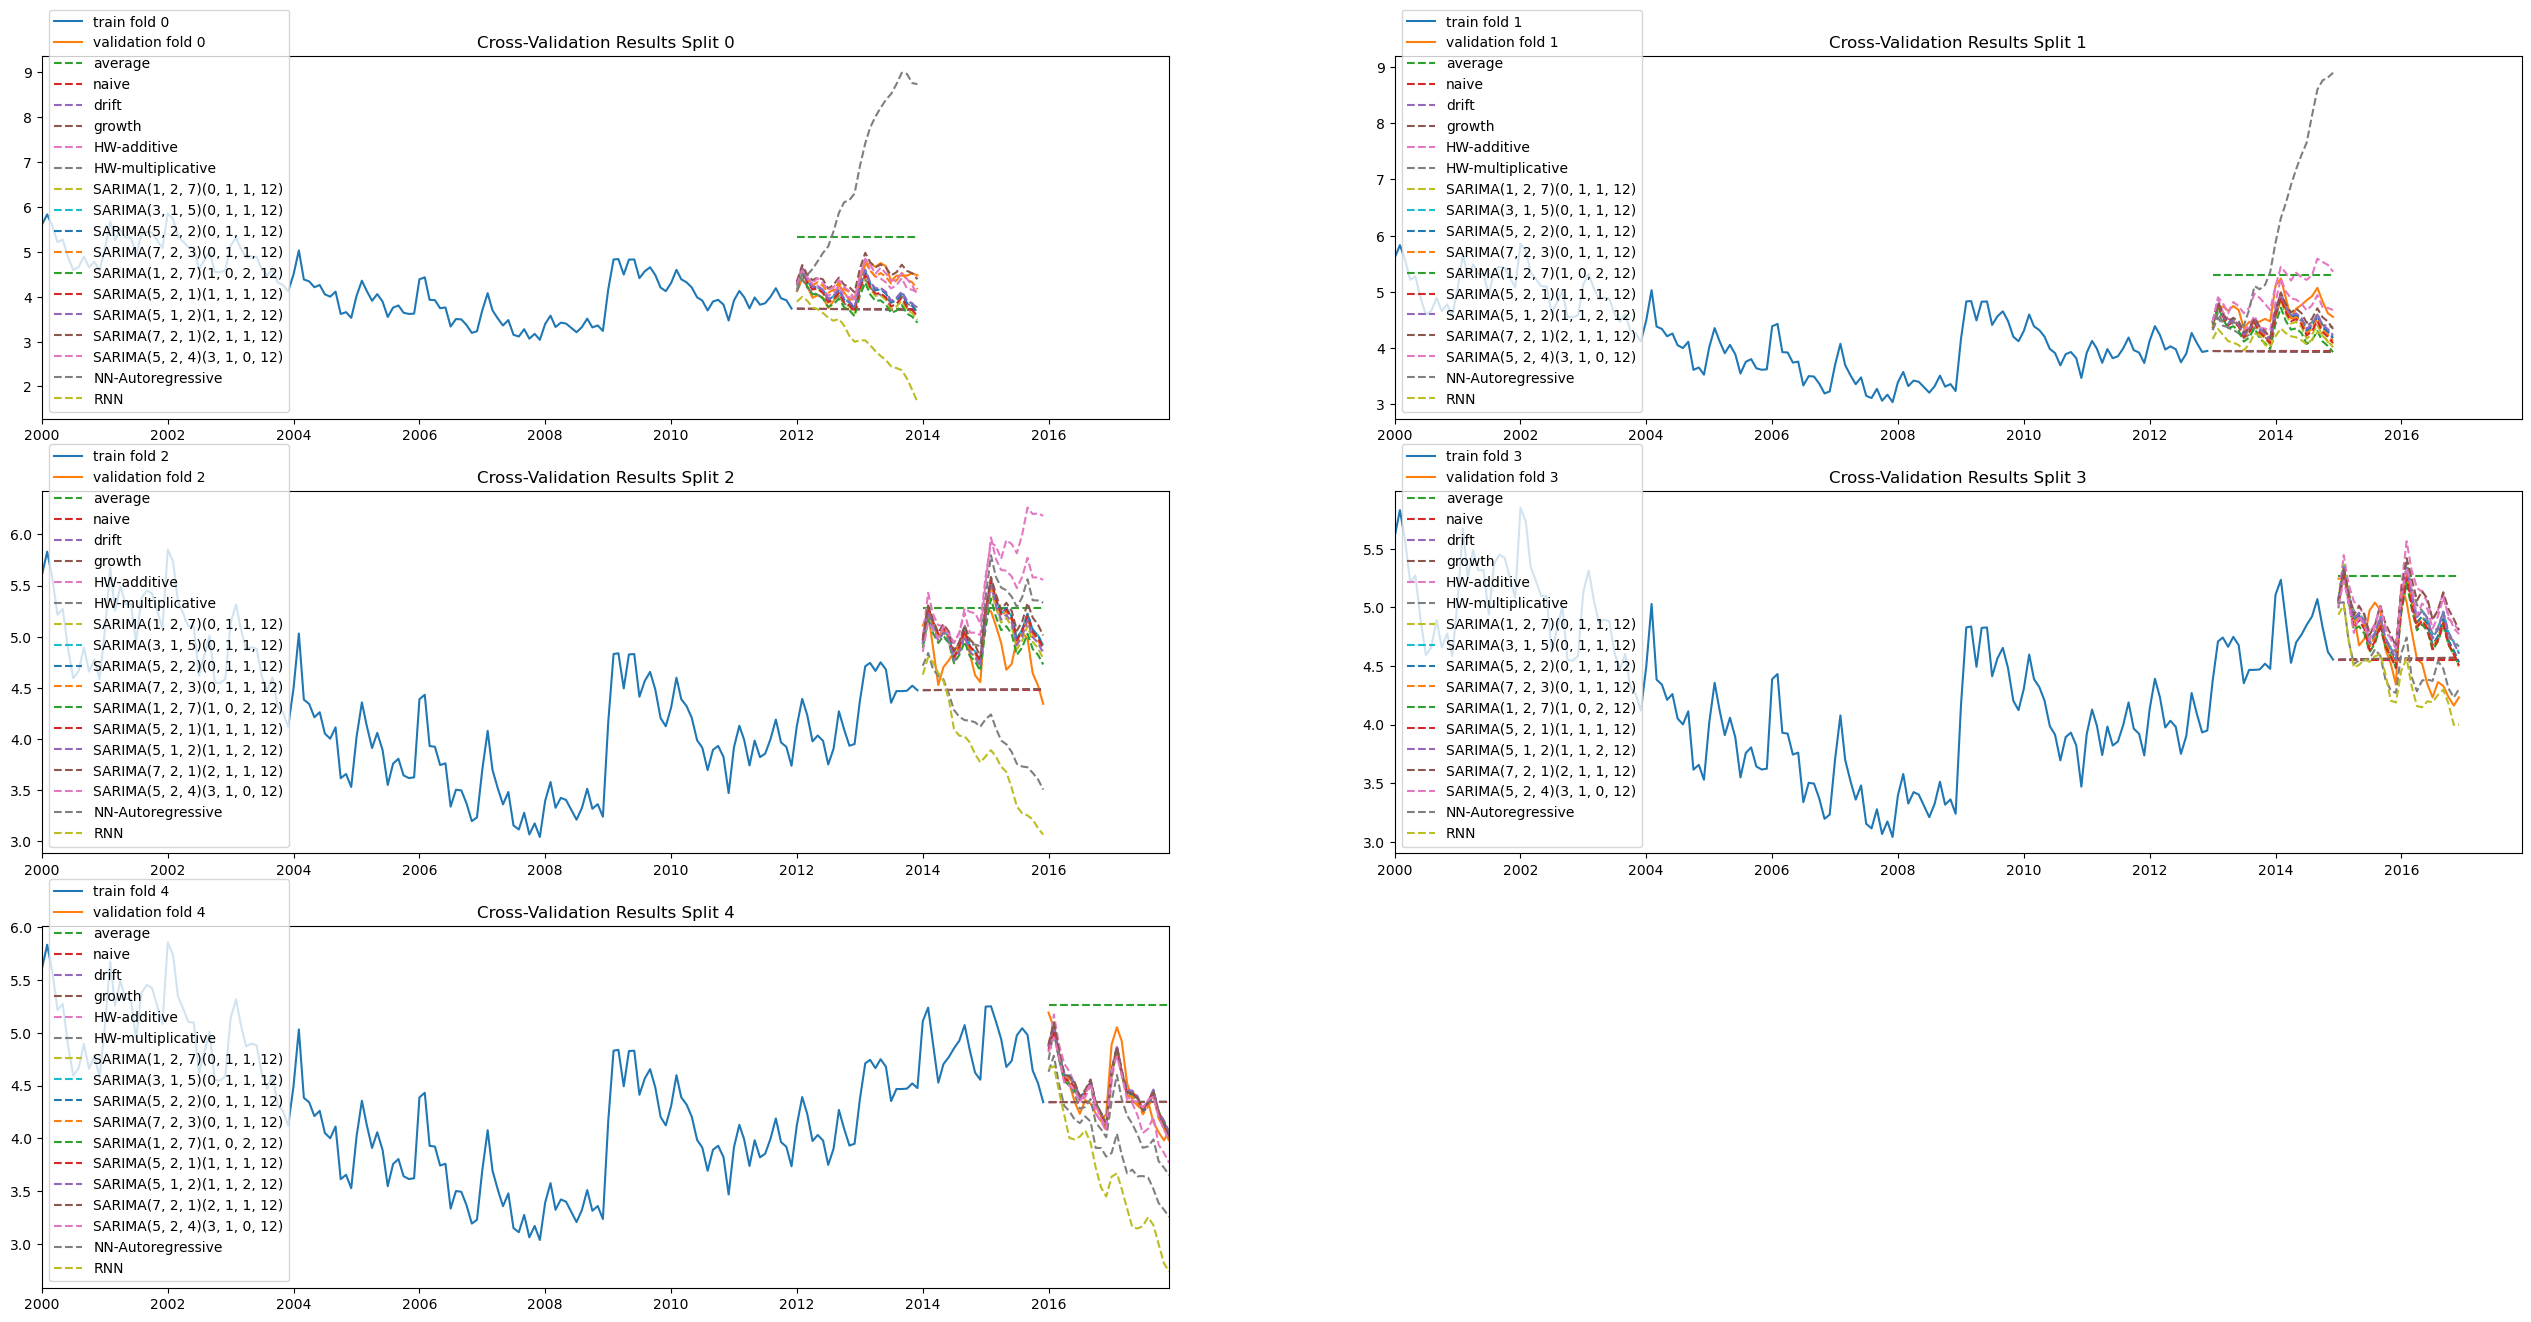

In [101]:
# Show prediction
plt.figure(figsize=(32,16))
start = pd.to_datetime('2000-01-01')
end = max(df_ts.index)

for i, (df_train, df_val) in enumerate(zip(train_folds, val_folds)):
    ax = plt.subplot(3, 2, i+1)
    
    ax.set_title(f'Cross-Validation Results Split {i}')
    ax.set_xlim(start, end)
    ax.plot(df_train['2000':], label=f'train fold {i}')
    ax.plot(df_val, label=f'validation fold {i}')
    for results in cv_predictions[i]:
        plt.plot(df_val.index, cv_predictions[i][results], linestyle='dashed', label=results)
    ax.legend(loc='lower left')

plt.show()

In [102]:
validation_results = pd.DataFrame(cv_results,
                                  index=[val_folds[i].index[0].strftime(format='%Y-%m-%d') for i in range(len(val_folds))]
                                 )
avg_performance = validation_results.mean(axis=0)
validation_results = pd.concat([validation_results, avg_performance.to_frame(name='mean').T], axis=0)
print('The Results of Expanding Cross-Validation are:')
display(validation_results.style.format(precision=4))

The Results of Expanding Cross-Validation are:


,average,naive,drift,growth,HW-additive,HW-multiplicative,"SARIMA(1, 2, 7)(0, 1, 1, 12)","SARIMA(3, 1, 5)(0, 1, 1, 12)","SARIMA(5, 2, 2)(0, 1, 1, 12)","SARIMA(7, 2, 3)(0, 1, 1, 12)","SARIMA(1, 2, 7)(1, 0, 2, 12)","SARIMA(5, 2, 1)(1, 1, 1, 12)","SARIMA(5, 1, 2)(1, 1, 2, 12)","SARIMA(7, 2, 1)(2, 1, 1, 12)","SARIMA(5, 2, 4)(3, 1, 0, 12)",NN-Autoregressive,RNN
2012-01-01,1.0758,0.6407,0.6582,0.6569,0.2242,0.4165,0.4944,0.3770,0.3991,0.1918,0.5591,0.4535,0.3707,0.2408,0.2170,2.8530,1.5261
2013-01-01,0.6451,0.7835,0.7934,0.7930,0.1634,0.3165,0.3927,0.2890,0.3068,0.3296,0.4752,0.3575,0.2801,0.2255,0.4328,2.1235,0.5693
2014-01-01,0.4908,0.4534,0.4488,0.4487,0.6147,0.4692,0.2462,0.3043,0.3051,0.2836,0.2145,0.2995,0.2642,0.3555,0.8716,0.8047,1.0978
2015-01-01,0.6814,0.3768,0.3775,0.3776,0.4569,0.3550,0.3043,0.3433,0.3071,0.2896,0.2811,0.2893,0.3420,0.4527,0.4054,0.2769,0.3336
2016-01-01,0.8705,0.3572,0.3571,0.3571,0.1843,0.2845,0.1544,0.1587,0.1542,0.1541,0.1597,0.1576,0.1583,0.1556,0.1586,0.6016,0.9080
mean,0.7527,0.5223,0.5270,0.5267,0.3287,0.3683,0.3184,0.2945,0.2945,0.2497,0.3379,0.3115,0.2831,0.2860,0.4171,1.3319,0.8870


**Based on the results, the best model(s) to forecast underemployment rate are:**
- Holt-Winters Additive Model & Holt-Winters Multiplicative Model
- SARIMA x 2

<a id="5.0"></a>
### 5.0 Evaluation on Test Set
- Load Test Data
- Retrain Final Model on All Training Data
- Evaluate on Test Set

[Return to top](#ToC)

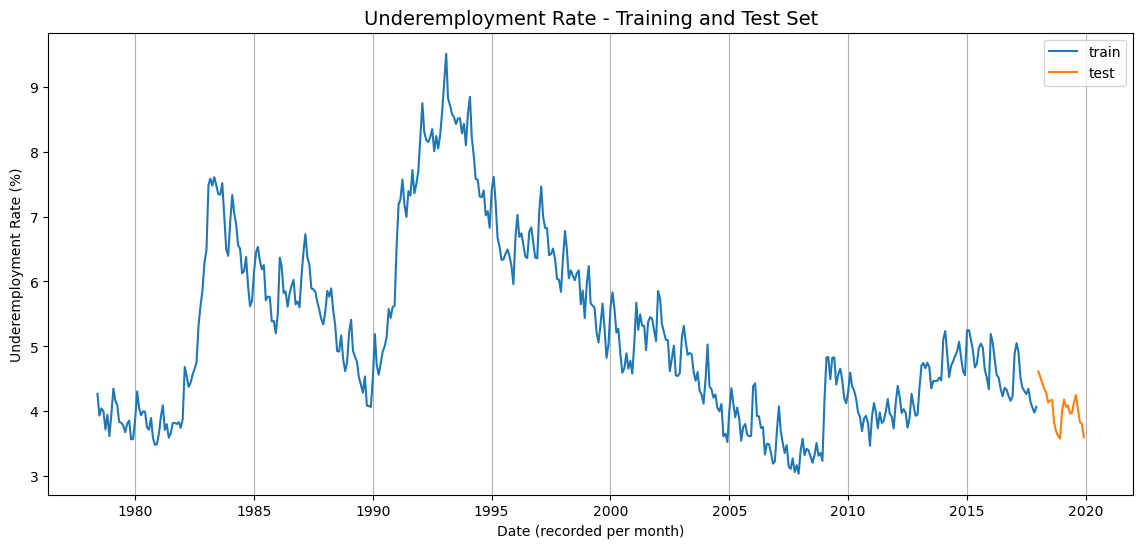

In [103]:
# load test data and prepare in the same was as the training set
df_test = pd.read_csv('data/UnderemploymentRate_OutofSample.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'], format="%d/%m/%Y")
df_test = df_test.set_index('Date')
df_test.index.freq = 'MS'

# Plot the training dataset
plt.figure(figsize=(14,6))
plt.title('Underemployment Rate - Training and Test Set', fontsize=14)
plt.xlabel('Date (recorded per month)', fontsize=10)
plt.ylabel('Underemployment Rate (%)', fontsize=10)

plt.gca().xaxis.grid(True)
plt.plot(df_ts, label='train')
plt.plot(df_test, label='test')

plt.legend()
plt.show()

In [105]:
import time

fold_time = time.time()
model_test_preds = dict()
model_test_results = dict()

# Fit and Forecast Baseline
for model_key in baseline_models:
    baseline_models[model_key].fit(df_ts)
    y_preds = baseline_models[model_key].predict(len(df_test))
    model_preds[model_key] = y_preds
    model_results[model_key] = RMSE(df_test, y_preds)

# Fit and Forecast Holt-Winters
for HW_seasonal in ['additive', 'multiplicative']:
    hw_model = ExponentialSmoothing(df_ts, seasonal_periods=12, trend='add', seasonal=HW_seasonal).fit()
    y_preds = hw_model.forecast(len(df_test))
    model_preds['HW-'+HW_seasonal] = y_preds
    model_results['HW-'+HW_seasonal] = RMSE(df_test, y_preds)

# Fit and Forecast Seasonal ARIMA
for order, seasonal_order in SARIMA_models.values():
    SARIMA_model = sm.tsa.statespace.sarimax.SARIMAX(df_ts, 
                                                     order = order,
                                                     seasonal_order = seasonal_order,
                                                     enforce_stationarity = False,
                                                     enforce_invertibility = False,
                                            ).fit(maxiter=200)
    y_preds = SARIMA_model.forecast(len(df_test))
    model_preds['SARIMA'+str(order)+str(seasonal_order)] = y_preds
    model_results['SARIMA'+str(order)+str(seasonal_order)] = RMSE(df_test, y_preds)

# Fit and Forecast Neural Nets
## Create training data
train_scaled = scaler.fit_transform(df_ts)
X_scaled, y_scaled = [], []
for i in range(time_window, len(df_ts)):
    X_scaled.append(train_scaled[i-time_window:i])
    y_scaled.append(train_scaled[i])

X_scaled = np.array(X_scaled).reshape(-1,time_window)
y_scaled = np.array(y_scaled).reshape(-1,1)

FFN_model.fit(X_scaled, y_scaled, epochs=50, batch_size=20, verbose=0)

## For 24 step ahead, use next prediction as the input for the next time step
## For FNN
X_test_scaled = train_scaled[-time_window:].reshape(-1,time_window)
y_preds_scaled = []
for step in range(time_window):
    next_pred = FFN_model.predict(X_test_scaled, verbose=0)
    y_preds_scaled.append(next_pred)

    ## Update X_test
    X_test_scaled = np.concatenate([X_test_scaled[:,1:], next_pred], axis=1)

y_preds = scaler.inverse_transform(np.array(y_preds_scaled).reshape(-1,1))
model_preds['NN-Autoregressive'] = y_preds
model_results['NN-Autoregressive'] = RMSE(df_test, y_preds)

## For RNN
X_scaled = X_scaled.reshape(-1,1,time_window)
RNN_model.fit(X_scaled, y_scaled, epochs=50, batch_size=12, verbose=0)

X_test_scaled = train_scaled[-time_window:].reshape(-1,1,time_window)
y_preds_scaled = []
for step in range(time_window):
    next_pred = RNN_model.predict(X_test_scaled, verbose=0)
    y_preds_scaled.append(next_pred)

    ## Update X_test
    X_test_scaled = np.concatenate([X_test_scaled[:,:,1:], np.expand_dims(next_pred, axis=2)], axis=2)

y_preds = scaler.inverse_transform(np.array(y_preds_scaled).reshape(-1,1))
model_preds['RNN'] = y_preds
model_results['RNN'] = RMSE(df_test, y_preds)

print(f'Forecast and scoring on test data complete. Total Time = {(time.time()-fold_time)/60:.4f} minutes')    

C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast and scoring on test data complete. Total Time = 3.1908 minutes


In [106]:
pd.DataFrame(model_results, index=['Test RMSE']).style.format(precision=4)

,average,naive,drift,growth,HW-additive,HW-multiplicative,"SARIMA(1, 2, 7)(0, 1, 1, 12)","SARIMA(3, 1, 5)(0, 1, 1, 12)","SARIMA(5, 2, 2)(0, 1, 1, 12)","SARIMA(7, 2, 3)(0, 1, 1, 12)","SARIMA(1, 2, 7)(1, 0, 2, 12)","SARIMA(5, 2, 1)(1, 1, 1, 12)","SARIMA(5, 1, 2)(1, 1, 2, 12)","SARIMA(7, 2, 1)(2, 1, 1, 12)","SARIMA(5, 2, 4)(3, 1, 0, 12)",NN-Autoregressive,RNN
Test RMSE,1.1927,0.2782,0.2763,0.2763,0.3170,0.1940,0.3519,0.3927,0.3279,0.3187,0.3265,0.3218,0.4328,0.3106,0.2287,0.3355,0.7104


In [ ]:
combined_HW = (model_preds['HW-additive'] + model_preds['HW-multiplicative'])/2
RMSE(df_test, combined_HW)

In [ ]:
combined_SARIMA = (model_preds['SARIMA(1, 1, 1)(1, 0, 1, 12)'] + model_preds['SARIMA(1, 2, 1)(2, 1, 1, 12)'])/2
RMSE(df_test, combined_SARIMA)

In [ ]:
combined_NN = (model_preds['NN-Autoregressive'] + model_preds['RNN'])/2
RMSE(df_test, combined_NN)

### OTHER